In [1]:
import numpy as np, matplotlib.pyplot as plt, xarray as xr, netCDF4 as nc, wrf
from mpltern.ternary.datasets import get_triangular_grid
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy as cp
from analysis_utils import *
#from sklearn import cluster
#import sklearn as sk
from sklearn.preprocessing import normalize
import PIL, tqdm, os
#from scipy import stats
import seaborn as sns
#from matplotlib.cm import get_cmap
#from cartopy.feature import NaturalEarthFeature
from joblib import Parallel, delayed
from tqdm_joblib import tqdm_joblib
import haversine as hs
import statsmodels.stats.api as sms
from ipywidgets import interact, IntSlider
from joblib.externals.loky import set_loky_pickler, wrap_non_picklable_objects
import pickle
from datetime import datetime
import functools
import operator
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import TwoSlopeNorm
import matplotlib.ticker as mticker
import datetime as dt
import scipy.stats as ss
set_loky_pickler("dill")
plt.rc('text', usetex=True)

/nird/projects/NS9600K/sldam/MINICONDA/masterenv/lib/python3.10/site-packages/mpltern/ternary/datasets.py:9: UserWarning: `mpltern.ternary.datasets.py` has been moved to `mpltern.datasets.py` and will be removed from the present directory in mpltern 0.6.0.
  warnings.warn(msg)
/nird/projects/NS9600K/sldam/MINICONDA/masterenv/lib/python3.10/site-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
#Milbrandt3 = '/nird/projects/NS9600K/brittsc/WRF_output_Stian/Milbrandt_d03_red_2'
#Milbrandt2 = '/nird/projects/NS9600K/brittsc/WRF_output_Stian/Milbrandt_d02_reduced_full'

MorrisonDefault3 = '/nird/projects/NS9600K/brittsc/211108_WRF_NYA/wrfout_d03_2019-11-11_12:00:00'
MorrisonDefaultSIP3 = '/nird/projects/NS9600K/brittsc/230123_Morrison_def_SIP_mod_HM_limits/wrfout_d03_2019-11-11_12:00:00'
MorrisonAdapted3 = '/nird/projects/NS9600K/brittsc/221126_Morrison_adapted_no_SIP/wrfout_d03_2019-11-11_12:00:00'
MorrisonAdaptedSIP3 = '/nird/projects/NS9600K/brittsc/230213_Morrison_moved_NISG_SIP/wrfout_d03_2019-11-11_12:00:00'

MorrisonDefault2 = '/nird/projects/NS9600K/brittsc/211108_WRF_NYA/wrfout_d02_2019-11-11_12:00:00'
MorrisonDefaultSIP2 = '/nird/projects/NS9600K/brittsc/230123_Morrison_def_SIP_mod_HM_limits/wrfout_d02_2019-11-11_12:00:00'
MorrisonAdapted2 = '/nird/projects/NS9600K/brittsc/221126_Morrison_adapted_no_SIP/wrfout_d02_2019-11-11_12:00:00'
MorrisonAdaptedSIP2 = '/nird/projects/NS9600K/brittsc/230213_Morrison_moved_NISG_SIP/wrfout_d02_2019-11-11_12:00:00'

MorrisonDefault1 = '/nird/projects/NS9600K/brittsc/211108_WRF_NYA/wrfout_d01_2019-11-11_12:00:00'
MorrisonDefaultSIP1 = '/nird/projects/NS9600K/brittsc/230123_Morrison_def_SIP_mod_HM_limits/wrfout_d01_2019-11-11_12:00:00'
MorrisonAdapted1 = '/nird/projects/NS9600K/brittsc/221126_Morrison_adapted_no_SIP/wrfout_d01_2019-11-11_12:00:00'
MorrisonAdaptedSIP1 = '/nird/projects/NS9600K/brittsc/230213_Morrison_moved_NISG_SIP/wrfout_d01_2019-11-11_12:00:00'

d3 = [MorrisonDefault3, MorrisonDefaultSIP3, MorrisonAdapted3, MorrisonAdaptedSIP3]
d2 = [MorrisonDefault2, MorrisonDefaultSIP2, MorrisonAdapted2, MorrisonAdaptedSIP2]

#Mil2 = xr.open_dataset(Milbrandt2, engine='netcdf4')
#Mil3 = xr.open_dataset(Milbrandt3, engine='netcdf4')

def convert(datapath=None, t1=144, t2=None, dom='d03', xslice=slice(None, None), yslice=slice(None, None)):
    set_loky_pickler("dill")
    global domain
    domain = dom
    #MD3 = xr.open_dataset(MorrisonDefault3, engine='netcdf4').isel(Time=slice(200, -1), bottom_top=slice(0, 85))
    #MDS3 = xr.open_dataset(MorrisonDefaultSIP3, engine='netcdf4').isel(Time=slice(200, -1), bottom_top=slice(0, 85))
    #MA3 = xr.open_dataset(MorrisonAdapted3, engine='netcdf4').isel(Time=slice(200, -1), bottom_top=slice(0, 85))
    if domain == 'd03':
        data = xr.open_dataset(datapath, engine='netcdf4').isel(bottom_top=slice(0, 85), 
                                                                bottom_top_stag=slice(0, 85), 
                                                                west_east=xslice,
                                                                south_north=yslice,
                                                                Time=slice(t1, t2))
    
    else:
        data = xr.open_dataset(datapath, engine='netcdf4').isel(bottom_top=slice(0, 85), 
                                                                bottom_top_stag=slice(0, 85), 
                                                                west_east=xslice,
                                                                south_north=yslice,
                                                                Time=slice(12, -1))


    def parallel_rhos(i, domain='d03'):
        import xarray as xr, wrf
        #datas = ['/nird/projects/NS9600K/brittsc/211108_WRF_NYA/wrfout_d03_2019-11-11_12:00:00']#,
        #datas = ['/nird/projects/NS9600K/brittsc/230105_Morrison_SIP_default_CDNC_INP/wrfout_d03_2019-11-11_12:00:00']
        datas = [datapath]
        #datas = ['/nird/projects/NS9600K/brittsc/230213_Morrison_moved_NISG_SIP/wrfout_d03_2019-11-11_12:00:00']
        if domain == 'd03':
            data = xr.open_dataset(datapath, engine='netcdf4').isel(bottom_top=slice(0, 85), 
                                                                    bottom_top_stag=slice(0, 85), 
                                                                    Time=slice(144, None))
        else:
            data = xr.open_dataset(datapath, engine='netcdf4').isel(bottom_top=slice(0, 85), 
                                                                    bottom_top_stag=slice(0, 85), 
                                                                    Time=slice(12, -1))

        P = data['P'] + data['PB']
        theta = data['T'] + 300 #+ data['T00'] NO clue why
        T = wrf.tk(P, theta)
        Tv = wrf.tvirtual(T, data['QVAPOR'], units='K')
        d = P / (287 * Tv)
        return d

    print('Calculating density')
    #with tqdm_joblib('Calculating density', total=1) as progress_bar:
    #    rhos = Parallel(n_jobs=4)(delayed(parallel_rhos)(i, domain=domain) for i in range(1))
    rhos = [parallel_rhos(0, domain=domain)]
    print('------------------------------------------------------')
    print('Converting units kg/kg -> g/m3')
    for i, da in enumerate([data]):#, MA3, data]):
        convert_vars_gm3 = ['QVAPOR', 'QCLOUD', 'QRAIN', 'QICE', 'QSNOW', 'QGRAUP']
        for var in tqdm.tqdm(convert_vars_gm3, desc=f'Dataset {i + 1}/1'):
            with xr.set_options(keep_attrs=True):
                da[var] = convert_to_gm3(da[var], rhos[i])
                da[var].attrs['units'] = 'g m-3'
    return data


domain='d03'
#MD3 = convert(MorrisonDefault3, dom='d03')


### Calculating spatial segments

In [13]:
def spatial_helper(datapath, filename):
    print('\n Starting with ', filename)
    data = xr.open_dataset(datapath, engine='netcdf4').isel(Time=slice(144, None), bottom_top=slice(0, 85))
    converted = convert(datapath)
    segment_data = segment_lengths_alongwind(converted, datapath, condition='> 0.5', 
                                            from_time=0, to_time=None, mass=True, cld_thrsh=0.5, 
                                            n_levels=7, phase_thrsh=0.1, transect_step=5, alongwind=True)
    store(segment_data, f'analysis_data/spatial_segments/ice/{filename}_mass_along.pkl')

datapaths = [MorrisonDefault3, MorrisonDefaultSIP3, MorrisonAdapted3, MorrisonAdaptedSIP3]
filenames = ['MD3', 'MDS3', 'MA3', 'MAS3']
[spatial_helper(datapath, filename) for datapath, filename in zip(datapaths, filenames)]



 Starting with  MD3
Calculating density
------------------------------------------------------
Converting units kg/kg -> g/m3


Dataset 1/1: 100%|██████████| 6/6 [00:32<00:00,  5.37s/it]


Getting Cloud-Top...
Done. Elapsed time: 11.3407 seconds
Calculating IWF...
Done. Elapsed time: 8.0406 seconds


100%|██████████| 289/289 [1:05:22<00:00, 13.57s/it]



 Starting with  MDS3
Calculating density
------------------------------------------------------
Converting units kg/kg -> g/m3


Dataset 1/1: 100%|██████████| 6/6 [00:44<00:00,  7.47s/it]


Getting Cloud-Top...
Done. Elapsed time: 21.7509 seconds
Calculating IWF...
Done. Elapsed time: 6.1901 seconds


100%|██████████| 289/289 [1:00:15<00:00, 12.51s/it]



 Starting with  MA3
Calculating density
------------------------------------------------------
Converting units kg/kg -> g/m3


Dataset 1/1: 100%|██████████| 6/6 [00:46<00:00,  7.77s/it]


Getting Cloud-Top...
Done. Elapsed time: 20.0965 seconds
Calculating IWF...
Done. Elapsed time: 6.2477 seconds


100%|██████████| 289/289 [35:30<00:00,  7.37s/it]



 Starting with  MAS3
Calculating density
------------------------------------------------------
Converting units kg/kg -> g/m3


Dataset 1/1: 100%|██████████| 6/6 [00:44<00:00,  7.46s/it]


Getting Cloud-Top...
Done. Elapsed time: 21.6030 seconds
Calculating IWF...
Done. Elapsed time: 6.9804 seconds


100%|██████████| 289/289 [35:18<00:00,  7.33s/it]


[None, None, None, None]

In [14]:
def spatial_helper(datapath, filename):
    print('\n Starting with ', filename)
    data = xr.open_dataset(datapath, engine='netcdf4').isel(Time=slice(144, None), bottom_top=slice(0, 85))
    converted = convert(datapath)
    segment_data = segment_lengths_alongwind(converted, datapath, condition='== 0.5', 
                                            from_time=0, to_time=None, mass=True, cld_thrsh=0.5, 
                                            n_levels=7, phase_thrsh=0.1, transect_step=5, alongwind=True)
    store(segment_data, f'analysis_data/spatial_segments/mixed/{filename}_mass_along.pkl')

datapaths = [MorrisonDefault3, MorrisonDefaultSIP3, MorrisonAdapted3, MorrisonAdaptedSIP3]
filenames = ['MD3', 'MDS3', 'MA3', 'MAS3']

[spatial_helper(datapath, filename) for datapath, filename in zip(datapaths, filenames)]


 Starting with  MD3
Calculating density
------------------------------------------------------
Converting units kg/kg -> g/m3


Dataset 1/1: 100%|██████████| 6/6 [00:36<00:00,  6.15s/it]


Getting Cloud-Top...
Done. Elapsed time: 15.5824 seconds
Calculating IWF...
Done. Elapsed time: 6.7347 seconds


100%|██████████| 289/289 [1:35:31<00:00, 19.83s/it]  



 Starting with  MDS3
Calculating density
------------------------------------------------------
Converting units kg/kg -> g/m3


Dataset 1/1: 100%|██████████| 6/6 [00:42<00:00,  7.13s/it]


Getting Cloud-Top...
Done. Elapsed time: 14.1510 seconds
Calculating IWF...
Done. Elapsed time: 6.5466 seconds


100%|██████████| 289/289 [1:31:27<00:00, 18.99s/it]  



 Starting with  MA3
Calculating density
------------------------------------------------------
Converting units kg/kg -> g/m3


Dataset 1/1: 100%|██████████| 6/6 [00:40<00:00,  6.71s/it]


Getting Cloud-Top...
Done. Elapsed time: 12.4263 seconds
Calculating IWF...
Done. Elapsed time: 6.4474 seconds


100%|██████████| 289/289 [48:39<00:00, 10.10s/it]



 Starting with  MAS3
Calculating density
------------------------------------------------------
Converting units kg/kg -> g/m3


Dataset 1/1: 100%|██████████| 6/6 [00:40<00:00,  6.75s/it]


Getting Cloud-Top...
Done. Elapsed time: 13.8874 seconds
Calculating IWF...
Done. Elapsed time: 6.3038 seconds


100%|██████████| 289/289 [48:44<00:00, 10.12s/it]


[None, None, None, None]

In [15]:
def spatial_helper(datapath, filename):
    print('\n Starting with ', filename)
    data = xr.open_dataset(datapath, engine='netcdf4').isel(Time=slice(144, None), bottom_top=slice(0, 85))
    converted = convert(datapath)
    segment_data = segment_lengths_alongwind(converted, datapath, condition='< 0.5', 
                                            from_time=0, to_time=None, mass=True, cld_thrsh=0.5, 
                                            n_levels=7, phase_thrsh=0.1, transect_step=5, alongwind=True)
    store(segment_data, f'analysis_data/spatial_segments/liquid/{filename}_mass_along.pkl')

datapaths = [MorrisonDefault3, MorrisonDefaultSIP3, MorrisonAdapted3, MorrisonAdaptedSIP3]
filenames = ['MD3', 'MDS3', 'MA3', 'MAS3']

[spatial_helper(datapath, filename) for datapath, filename in zip(datapaths, filenames)]


 Starting with  MD3
Calculating density
------------------------------------------------------
Converting units kg/kg -> g/m3


Dataset 1/1: 100%|██████████| 6/6 [00:37<00:00,  6.22s/it]


Getting Cloud-Top...
Done. Elapsed time: 15.1615 seconds
Calculating IWF...
Done. Elapsed time: 6.3825 seconds


100%|██████████| 289/289 [36:29<00:00,  7.58s/it]



 Starting with  MDS3
Calculating density
------------------------------------------------------
Converting units kg/kg -> g/m3


Dataset 1/1: 100%|██████████| 6/6 [00:44<00:00,  7.48s/it]


Getting Cloud-Top...
Done. Elapsed time: 13.9694 seconds
Calculating IWF...
Done. Elapsed time: 6.3927 seconds


100%|██████████| 289/289 [37:08<00:00,  7.71s/it]



 Starting with  MA3
Calculating density
------------------------------------------------------
Converting units kg/kg -> g/m3


Dataset 1/1: 100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Getting Cloud-Top...
Done. Elapsed time: 12.8089 seconds
Calculating IWF...
Done. Elapsed time: 6.7853 seconds


100%|██████████| 289/289 [1:43:09<00:00, 21.42s/it]



 Starting with  MAS3
Calculating density
------------------------------------------------------
Converting units kg/kg -> g/m3


Dataset 1/1: 100%|██████████| 6/6 [00:45<00:00,  7.54s/it]


Getting Cloud-Top...
Done. Elapsed time: 13.8826 seconds
Calculating IWF...
Done. Elapsed time: 6.6150 seconds


100%|██████████| 289/289 [1:41:48<00:00, 21.14s/it]


[None, None, None, None]

## Plot extents

In [ ]:
def plot_extent(ax, data, label, color='red'):
    ax.plot([data.XLONG.isel(Time=1, west_east=0, south_north=0), data.XLONG.isel(Time=1, west_east=0, south_north=-1)], 
            [data.XLAT.isel(Time=1, west_east=0, south_north=0), data.XLAT.isel(Time=1, west_east=0, south_north=-1).max()], 
            transform=ccrs.Geodetic(), color=color, linewidth=3)
    ax.plot([data.XLONG.isel(Time=1, west_east=0, south_north=-1), data.XLONG.isel(Time=1, west_east=-1, south_north=-1)], 
            [data.XLAT.isel(Time=1, west_east=0, south_north=-1), data.XLAT.isel(Time=1, west_east=-1, south_north=-1)], 
            transform=ccrs.Geodetic(), color=color, linewidth=3)
    ax.plot([data.XLONG.isel(Time=1, west_east=-1, south_north=-1), data.XLONG.isel(Time=1, west_east=-1, south_north=0)], 
            [data.XLAT.isel(Time=1, west_east=-1, south_north=-1), data.XLAT.isel(Time=1, west_east=-1, south_north=0)], 
            transform=ccrs.Geodetic(), color=color, linewidth=3)
    ax.plot([data.XLONG.isel(Time=1, west_east=-1, south_north=0), data.XLONG.isel(Time=1, west_east=0, south_north=0)], 
            [data.XLAT.isel(Time=1, west_east=-1, south_north=0), data.XLAT.isel(Time=1, west_east=0, south_north=0)], 
            transform=ccrs.Geodetic(), color=color, linewidth=3, label=label)

In [ ]:
label_style = {'size':11, 'color':'black'}
# Create a Figure, which doesn't have to be square.
fig = plt.figure(layout='constrained')
# Create the main axes, leaving 25% of the figure space at the top and on the
# right to position marginals.
ax2 = fig.add_gridspec(top=0.75, right=0.75).subplots(subplot_kw={'projection': ccrs.NorthPolarStereo(11.1)})
ax2.set(aspect=1)

ax2.scatter(11.94456029591745, 78.92759354100885, transform=ccrs.PlateCarree(), 
            color='red', marker='*', edgecolor='k', label='NyA')

plot_extent(ax2, data3, label='d03', color='k')
plot_extent(ax2, data2, label='d02', color='maroon')
plot_extent(ax2, data1, label='d01', color='navy')
#ax2.legend(loc='upper left')
ax2.add_feature(cf.OCEAN)
ax2.add_feature(cf.LAND)
ax2.add_feature(cf.LAKES)
ax2.add_feature(cf.RIVERS)

ax2.gridlines(draw_labels=False, color='black', x_inline=False, y_inline=False)

gl = ax2.gridlines(draw_labels=True, x_inline=False, y_inline=False)
gl.xlines = gl.ylines = False
gl.rotate_labels = False
gl.right_labels = False
gl.bottom_labels = True

gl.xlabel_style = gl.ylabel_style = label_style

plt.legend(handles=[], )


ax2.legend(loc='lower left', edgecolor='k', fontsize=14, handlelength=1)

axH = ax2.inset_axes([1.03, 0, 0.25, 1])
# Draw the scatter plot and marginals.
axH.hist(H/1000, orientation='horizontal', bins=np.arange(0, 18.1, 1), color='maroon', edgecolor='k')
axH.set_ylim(0, 18)

axH.set_ylabel('altitude [km]', size=12)
axH.yaxis.set_label_position("right")
axH.yaxis.tick_right()
axH.set_xlabel('model levels', size=12)

#fig.suptitle('Domain extents and model levels', size=18, y=0.96)
plt.savefig('../plots/ModelDomain')
plt.show()

### Helpers

In [8]:
def all_ice(data, t=None, mass=True):
    if mass:
        vars = ['QICE', 'QGRAUP', 'QSNOW']
    else:
        vars = ['QNICE', 'QNSNOW', 'QNGRAUPEL']

    if t is not None:
        ice = data[vars[0]].isel(Time=t).where(data[vars[0]].isel(Time=t) > 0, other=0)
        for e in vars[1:]:
            ice += data[e].isel(Time=t).where(data[e].isel(Time=t) > 0, other=0)
        return ice

    else:
        ice = data[vars[0]].where(data[vars[0]] > 0, other=0)
        for e in vars[1:]:
            ice += data[e].where(data[e] > 0, other=0)
        return ice

def all_liquid(data, t=None, mass=True):
    if mass:
        vars = ['QCLOUD', 'QRAIN']
    else:
        vars = ['QNCLOUD', 'QNRAIN']

    if t is not None:
        liquid = data[vars[0]].isel(Time=t).where(data[vars[0]].isel(Time=t) > 0, other=0) + \
        data[vars[1]].isel(Time=t).where(data[vars[1]].isel(Time=t) > 0, other=0)
        return liquid

    else:
        liquid = data[vars[0]].where(data[vars[0]] > 0, other=0) + \
        data[vars[1]].where(data[vars[1]] > 0, other=0)
        return liquid

def cldmsk(inp, data, t=None, cld_thrsh=0.10):
    if t is not None:
        return inp * xr.where(data.CLDFRA.isel(Time=t) > cld_thrsh, x=1, y=np.nan)
    else:
        return inp * xr.where(data.CLDFRA > cld_thrsh, x=1, y=np.nan)

def clip_to_region(data, datapath, minll=(78, 11), maxll=(79, 12), clip_to_data=None):#minlat, minlon, maxlat, maxlon):
    if clip_to_data is not None:
        Ds = nc.Dataset(clip_to_data)
        mxx, mxy = Ds['XLONG'].shape[2] - 1, Ds['XLONG'].shape[1] - 1
        minll = wrf.xy_to_ll(Ds, 0, 0)
        maxll = wrf.xy_to_ll(Ds, mxy, mxx)
        
    minx, miny = [int(e) for e in wrf.ll_to_xy(nc.Dataset(datapath), float(minll[0]), float(minll[1]))]
    maxx, maxy = [int(e) for e in wrf.ll_to_xy(nc.Dataset(datapath), float(maxll[0]), float(maxll[1]))]
    return data.isel(west_east=slice(minx, maxx), south_north=slice(miny, maxy))

def lndmsk(data):
    return xr.where(data.XLAND.isel(Time=1) == 1, x=1, y=np.nan)

def wtrmsk(data):
    return xr.where(data.XLAND.isel(Time=1) == 2, x=1, y=np.nan)
    
def iwf_calc(data, mass=True, t=None, cld_thrsh=0.5):
    ALL_ICE = all_ice(data, mass=mass, t=t)
    ALL_LIQUID = all_liquid(data, mass=mass, t=t)
    return cldmsk(ALL_ICE / (ALL_ICE + ALL_LIQUID), data=data, cld_thrsh=cld_thrsh, t=t)

def composition_msk(data, thrsh=0.05, iwf=None, mass=True):
    if iwf is None:
        iwf = iwf_calc(data, mass=mass)

    mixed = iwf.where(iwf > thrsh, other=np.nan)
    mixed = xr.where(mixed < 1 - thrsh, x = 1, y=np.nan)

    ice = xr.where(iwf > 1 - thrsh, x=1, y=np.nan)
    liquid = xr.where(iwf < thrsh, x=1, y=np.nan)
    return liquid, mixed, ice

def find_top(data, datapath, cld_thrsh=0.1, t=None, xslice=(None, None), yslice=(None, None)):
    h = wrf.getvar(nc.Dataset(datapath), 'z').isel(west_east=xslice, south_north=yslice).to_numpy()

    if t is not None:
        hc = xr.where(data.CLDFRA.isel(Time=t, bottom_top=slice(0,84)) > cld_thrsh, x=1, y=0) * h[:84, :, :]
    else:
        hc = xr.where(data.CLDFRA.isel(bottom_top=slice(0,84)) > cld_thrsh, x=1, y=0) * h[:84, :, :]
    
    cloudtop = hc.argmax(dim='bottom_top')
    return cloudtop.rename('Cloud-top level')

def select_top(indata, cloudtop, n_levels=10):
    return indata.where((indata.bottom_top > cloudtop - n_levels) 
                        & (indata.bottom_top <= cloudtop) 
                        & (indata.bottom_top != 0), other=np.nan)

def find_base(data, datapath, cld_thrsh=0.1, t=None, xslice=(None, None), yslice=(None, None)):
    h = wrf.getvar(nc.Dataset(datapath), 'z').isel(west_east=xslice, south_north=yslice).to_numpy()

    if t is not None:
        hc = xr.where(data.CLDFRA.isel(Time=t, bottom_top=slice(0,84)) > cld_thrsh, x=1, y=0) * h[:84, :, :]
    else:
        hc = xr.where(data.CLDFRA.isel(bottom_top=slice(0,84)) > cld_thrsh, x=1, y=np.nan) * h[:84, :, :]

    cloudbase = hc.argmin(dim='bottom_top')
    return cloudbase.rename('Cloud-base level')

def select_base(indata, cloudbase, n_levels=10):
    return indata.where((indata.bottom_top < cloudbase + n_levels) 
                        & (indata.bottom_top >= cloudbase) 
                        & (indata.bottom_top != 0), other=np.nan)

def calc_T(data, t):
    return wrf.tk(data.P.isel(Time=t) + data.PB.isel(Time=t), data.T.isel(Time=t) + 300) - 273.15
def calc_W(data, t):
    return wrf.destagger(data.W.isel(Time=t), stagger_dim=1, meta=True)

def consecutive(arr):
    return np.split(arr, np.where(np.diff(arr) != 1)[0] + 1)

def animate(plot_func, data, n_timesteps='all', step_interval=1, anim_title='animation', duration=200, mp4=False, skip_spinup=0):
    '''
    Create an animation of time evolution through iterating a plotting function.
    Parameters:
    -----------
    plot_func        - (function) function for generating figure with one or more subplots
    step_interval    - (int) number of timesteps to forward each frame in animation, default is 1
    n_frames         - (int) number of frames to use in animation, default is None (full timerange is used)
    anim_title       - (string) name of the saved gif (without extension), default is 'animation'
    duration         - (int) time in seconds determining the length of the animation (determines also the speed), default is 200
    skip_spinup      - (int) number of timesteps to skip due to model spinup time, default is 0
    '''
    
    frames = []
    if n_timesteps == 'all':
        n_timesteps = len(data['XTIME'][:]) - skip_spinup
    for frame in tqdm.tqdm(range(skip_spinup, skip_spinup + n_timesteps)):
        framename = f'/tos-project2/NS9600K/brittsc/WRF_output_Stian/plots/{frame}.png'
        t = frame * step_interval
        fig = plot_func(frame, data=data)
        fig.savefig(f'/tos-project2/NS9600K/brittsc/WRF_output_Stian/plots/{frame}')
        frames.append(PIL.Image.open(framename))
        plt.close()
        os.remove(framename)
    
    title = f'/tos-project2/NS9600K/brittsc/WRF_output_Stian/animations/{anim_title}.gif'
    frames[0].save(title, format='GIF', append_images=frames[1:], save_all=True, duration=duration, loop=1)

import time
class timer:
    def __init__(self):
        self._start_time = None
        self._round_time = None

    def start(self):
        self._start_time = time.perf_counter()

    def round(self):
        if self._round_time is None:
            t = time.perf_counter() - self._start_time
            self._round_time = time.perf_counter()
        else:
            t = time.perf_counter() - self._round_time
            self._round_time = time.perf_counter()
        return f'Elapsed time: {t:0.4f} seconds'
    
    def stop(self):
        t = time.perf_counter() - self._start_time
        self._start_time = None
        self._round_time = None
        return f'Elapsed time: {t:0.4f} seconds.'

def flatten_list(lst):
    try:
        return functools.reduce(operator.iconcat, lst, [])
    except TypeError:
        return []

def store(data, filename):
    with open('MD3_mass_along.pkl', 'wb') as file:
        pickle.dump(data, file, protocol=-1)

def load(filename):
    with open(filename, 'rb') as file:
        return pickle.load(file)





In [ ]:
def f(x):
    MD3.QNICE.isel(Time=x).sum(dim='south_north').plot(levels=np.arange(0, 15001, 100), cmap='Reds')

interact(f, x=IntSlider(min=0, max=231))

In [92]:
MD3

<xarray.Dataset>
Dimensions:                (Time: 289, south_north: 100, west_east: 100,
                            bottom_top: 85, bottom_top_stag: 172,
                            soil_layers_stag: 4, west_east_stag: 101,
                            south_north_stag: 101, seed_dim_stag: 2)
Coordinates:
    XLAT                   (Time, south_north, west_east) float32 ...
    XLONG                  (Time, south_north, west_east) float32 ...
    XTIME                  (Time) datetime64[ns] ...
    XLAT_U                 (Time, south_north, west_east_stag) float32 ...
    XLONG_U                (Time, south_north, west_east_stag) float32 ...
    XLAT_V                 (Time, south_north_stag, west_east) float32 ...
    XLONG_V                (Time, south_north_stag, west_east) float32 ...
Dimensions without coordinates: Time, south_north, west_east, bottom_top,
                                bottom_top_stag, soil_layers_stag,
                                west_east_stag, south_north_stag, seed_dim_stag
Data variables: (12/203)
    Times                  (Time) |S19 ...
    LU_INDEX               (Time, south_north, west_east) float32 ...
    ZNU                    (Time, bottom_top) float32 ...
    ZNW                    (Time, bottom_top_stag) float32 ...
    ZS                     (Time, soil_layers_stag) float32 ...
    DZS                    (Time, soil_layers_stag) float32 ...
    ...                     ...
    PCB                    (Time, south_north, west_east) float32 ...
    PC                     (Time, south_north, west_east) float32 ...
    LANDMASK               (Time, south_north, west_east) float32 ...
    LAKEMASK               (Time, south_north, west_east) float32 ...
    SST                    (Time, south_north, west_east) float32 ...
    SST_INPUT              (Time, south_north, west_east) float32 ...
Attributes: (12/132)
    TITLE:                            OUTPUT FROM WRF V4.2.1 MODEL
    START_DATE:                      2019-11-11_12:00:00
    SIMULATION_START_DATE:           2019-11-11_12:00:00
    WEST-EAST_GRID_DIMENSION:        101
    SOUTH-NORTH_GRID_DIMENSION:      101
    BOTTOM-TOP_GRID_DIMENSION:       172
    ...                              ...
    ISLAKE:                          28
    ISICE:                           24
    ISURBAN:                         1
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2

In [3]:
#D = clip_to_region(Mil2, Milbrandt2, 
#                   wrf.xy_to_ll(nc.Dataset(Milbrandt3), 0, 0), 
#                   wrf.xy_to_ll(nc.Dataset(Milbrandt3), 99, 99))

#D = clip_to_region(Mil2, Milbrandt2, clip_to_data=Milbrandt3)

#D.T2.isel(Time=4).plot(x='XLONG', y='XLAT')

# All cloud

### Stats

In [3]:
IWF = iwf_calc(MD3, mass=True, cld_thrsh=0.5)
LIQUID, MIXED, ICE = composition_msk(MD3, iwf=IWF)

In [4]:
def print_stats(data, ice, mixed, liquid, iwf):
    print('Over land:')
    land = lndmsk(data)
    water = wtrmsk(data)
    print('Ice: ', int((ice * land).count()), ', ', round(float((ice * land).count() / (iwf * land).count()) * 100, 2), '%')
    print('Mixed: ', int((mixed * land).count()), ', ', round(float((mixed * land).count() / (iwf * land).count()) * 100, 2), '%')
    print('Liquid: ', int((liquid * land).count()), ', ', round(float((liquid * land).count() / (iwf * land).count()) * 100, 2), '%')
    print('Over water:')
    print('Ice: ', int((ice * water).count()), ', ', round(float((ice * water).count() / (iwf * water).count()) * 100, 2), '%')
    print('Mixed: ', int((mixed * water).count()), ', ', round(float((mixed * water).count() / (iwf * water).count()) * 100, 2), '%')
    print('Liquid: ', int((liquid * water).count()), ', ', round(float((liquid * water).count() / (iwf * water).count()) * 100, 2), '%')

In [5]:
print_stats(MD3, ICE, MIXED, LIQUID, IWF)

Over land:
Ice:  11329533 ,  20.52 %
Mixed:  3698131 ,  6.7 %
Liquid:  40179716 ,  72.78 %
Over water:
Ice:  11686807 ,  29.32 %
Mixed:  4201333 ,  10.54 %
Liquid:  23974251 ,  60.14 %


I just played around a bit with the number concentrations now and it looks like it doesn't change the structure that much. When I don't time the ice numbers by factor 1000 and just calculate the IWF as normal then the number of grid cells with "only" ice actually increases at the expense of mixed phase occurences. So all I see is that mixed phase occurence is reduced from 20% to 10% of all in-cloud grid cells. I guess that is logical since the balance is now just so dependent on presence of liquid - either there is liquid there to dominate (IWF=0), or not (IWF=1).

When I looked at the vertical structure it looks like the occurences of mixed phase still is right in between the pure ice top and the pure liquid middle of the cloud which makes sense. But I also took a look at some of these grid cells to see the composition and found that the liquid water in them is classified by wrf as rain and not cloud. Does that make any sense? How can the droplets at the very top of the cloud, above all of the other supercooled cloud droplets, be rain? Should they not be too heavy to form or be brought up here? Or is it just that these are the only ones large enough to "survive" the scavenging from the ice?  

### Animation

In [80]:
def animate(plot_func, n_timesteps='all', step_interval=1, anim_title='animation', duration=200, mp4=False, skip_spinup=0):
    '''
    Create an animation of time evolution through iterating a plotting function.
    Parameters:
    -----------
    plot_func        - (function) function for generating figure with one or more subplots
    step_interval    - (int) number of timesteps to forward each frame in animation, default is 1
    n_frames         - (int) number of frames to use in animation, default is None (full timerange is used)
    anim_title       - (string) name of the saved gif (without extension), default is 'animation'
    duration         - (int) time in seconds determining the length of the animation (determines also the speed), default is 200
    skip_spinup      - (int) number of timesteps to skip due to model spinup time, default is 0
    '''
    
    frames = []
    if n_timesteps == 'all':
        n_timesteps = len(Mil3['XTIME'][:]) - skip_spinup
    for frame in tqdm.tqdm(range(skip_spinup, skip_spinup + n_timesteps)):
        framename = f'/tos-project2/NS9600K/brittsc/WRF_output_Stian/plots/{frame}.png'
        t = frame * step_interval
        fig = plot_func(frame)
        fig.savefig(f'/tos-project2/NS9600K/brittsc/WRF_output_Stian/plots/{frame}')
        frames.append(PIL.Image.open(framename))
        plt.close()
        os.remove(framename)
    
    title = f'/tos-project2/NS9600K/brittsc/WRF_output_Stian/animations/{anim_title}.gif'
    frames[0].save(title, format='GIF', append_images=frames[1:], save_all=True, duration=duration, loop=1)
#animate(plot_CT, anim_title='CloudTopAnimation_d03')

## 2D Histograms

In [15]:
#t = slice(30, 60)
#T = wrf.tk(Mil3.P.isel(Time=t) + Mil3.PB.isel(Time=t), Mil3.T.isel(Time=t) + 300) - 273.15
#W = wrf.destagger(Mil3.W.isel(Time=t), stagger_dim=1, meta=True)

In [9]:
def hist_TWC(data, mass=True, t=slice(0, 30)):
    fig, ax = plt.subplots(1, 2, figsize=(10,5), sharey=True)
    # Over land

    IWF = iwf_calc(data, mass=mass, t=t)
    TWC = all_ice(data, t=t, mass=mass) + all_liquid(data, t=t, mass=mass)

    X = np.nan_to_num((IWF * lndmsk(data)).to_numpy().ravel())
    Y = np.nan_to_num((TWC * lndmsk(data)).to_numpy().ravel())

    plot = ax[0].hist2d(X, Y, norm=mpl.colors.LogNorm(), bins=[np.arange(0, 1.01, 0.05), 
    np.arange(0.01, 1.2, 0.05)], cmap='magma_r')
    ax[0].set_xlabel('IWF')
    ax[0].set_title('Over land')
    cbar = fig.colorbar(plot[3], ax=ax.ravel().tolist(), shrink=0.95, label='# of occurences')

    # Over water
    X = np.nan_to_num((IWF * wtrmsk(data)).to_numpy().ravel())
    Y = np.nan_to_num((TWC  * wtrmsk(data)).to_numpy().ravel())
    plot = ax[1].hist2d(X, Y, norm=mpl.colors.LogNorm(), bins=[np.arange(0, 1.01, 0.05), 
                                                            np.arange(0.01, 1.2, 0.05)], cmap='magma_r')
    ax[1].set_xlabel('IWF')
    ax[1].set_title('Over water')

    ax[0].set_ylabel('TWC [g/m3]')
    fig.suptitle(domain + ', ' + ['mass' if mass else 'number'][0])
    plt.show()

hist_TWC(MD3, mass=True)

RuntimeError: latex was not able to process the following string:
b'# of occurences'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpcg0grwxt dbf32df6c82478b3a5b39c73194317a5.tex

This is pdfTeX, Version 3.14159265-2.6-1.40.19 (TeX Live 2018) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./dbf32df6c82478b3a5b39c73194317a5.tex
LaTeX2e <2017-04-15>
Babel <3.17> and hyphenation patterns for 3 language(s) loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/utf8.def
(/usr/share/texlive/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/omsenc.dfu)))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty))
(/usr/share/texlive/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.dfu)))
No file dbf32df6c82478b3a5b39c73194317a5.aux.
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! You can't use `macro parameter character #' in vertical mode.
l.29 {\sffamily #
                  of occurences}%
No pages of output.
Transcript written on tmpcg0grwxt/dbf32df6c82478b3a5b39c73194317a5.log.




<Figure size 1000x500 with 3 Axes>

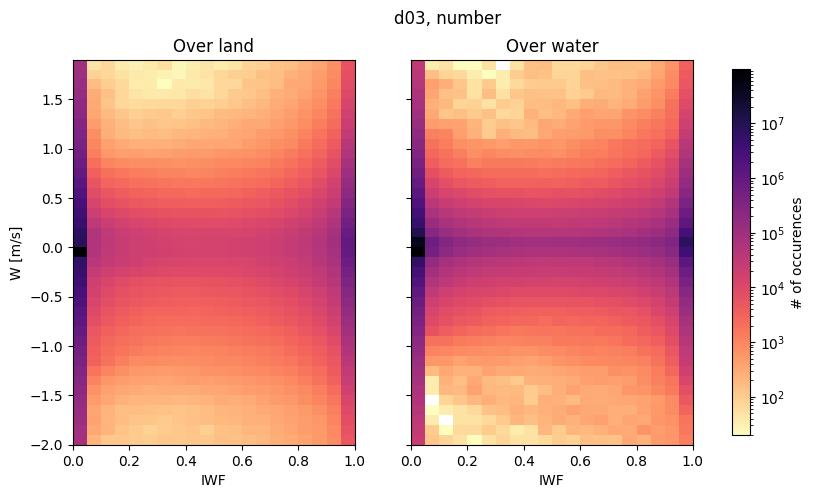

In [8]:
def hist_W(data, mass=True, t=slice(0, 30)):
    fig, ax = plt.subplots(1, 2, figsize=(10,5), sharey=True)
    # Over land

    IWF = iwf_calc(data, mass=mass, t=t)
    W = Mil3.W.isel(Time=t) # _W(data, t=t)

    X = np.nan_to_num((IWF * lndmsk(data)).to_numpy().ravel())
    Y = np.nan_to_num((W * lndmsk(data)).to_numpy().ravel())

    plot = ax[0].hist2d(X, Y, norm=mpl.colors.LogNorm(), bins=[np.arange(0, 1.01, 0.05), 
    np.arange(-2, 2, 0.1)], cmap='magma_r')
    ax[0].set_xlabel('IWF')
    ax[0].set_title('Over land')
    cbar = fig.colorbar(plot[3], ax=ax.ravel().tolist(), shrink=0.95, label='# of occurences')

    #bins=[[0, 0.05, 0.5, 0.95, 1.001]

    # Over water
    X = np.nan_to_num((IWF.isel(Time=t) * wtrmsk(data)).to_numpy().ravel())
    Y = np.nan_to_num((W * wtrmsk(data)).to_numpy().ravel())
    plot = ax[1].hist2d(X, Y, norm=mpl.colors.LogNorm(), bins=[np.arange(0, 1.01, 0.05), 
                                                            np.arange(-2, 2, 0.1)], cmap='magma_r')
    ax[1].set_xlabel('IWF')
    ax[1].set_title('Over water')
    #cbar = fig.colorbar(plot[3], ax=ax.ravel().tolist(), shrink=0.95)
    fig.suptitle(domain + ', ' + ['mass' if mass else 'number'][0])
    ax[0].set_ylabel('W [m/s]')
    plt.show()

hist_W(Mil3, mass=False, t=slice(0, 200))

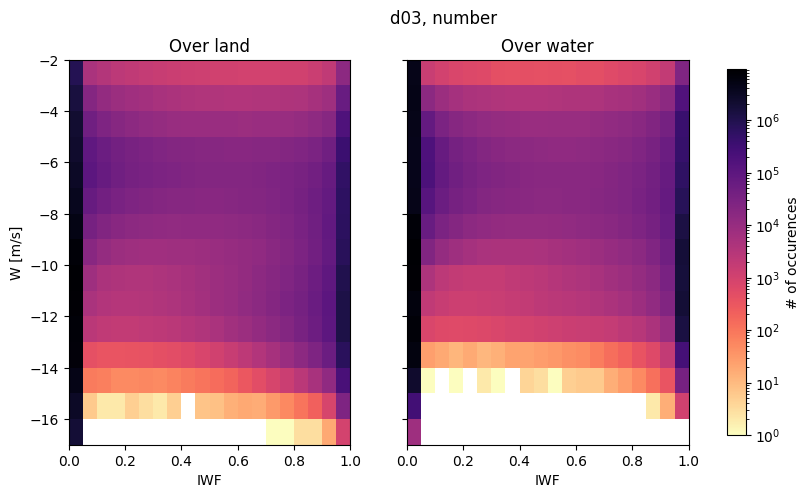

In [9]:
def hist_T(data, mass=True, t=slice(0, 30)):
    fig, ax = plt.subplots(1, 2, figsize=(10,5), sharey=True)
    # Over land

    IWF = iwf_calc(data, mass=mass, t=t)
    T = _T(data, t=t)

    X = np.nan_to_num((IWF * lndmsk(data)).to_numpy().ravel())
    Y = np.nan_to_num((T * lndmsk(data)).to_numpy().ravel())
    plot = ax[0].hist2d(X, Y, norm=mpl.colors.LogNorm(), bins=[np.arange(0, 1.01, 0.05), 
    np.arange(-17, -1, 1)], cmap='magma_r')
    ax[0].set_xlabel('IWF')
    ax[0].set_title('Over land')
    cbar = fig.colorbar(plot[3], ax=ax.ravel().tolist(), shrink=0.95, label='# of occurences')

    #bins=[[0, 0.05, 0.5, 0.95, 1.001]

    # Over water
    X = np.nan_to_num((IWF * wtrmsk(data)).to_numpy().ravel())
    Y = np.nan_to_num((T * wtrmsk(data)).to_numpy().ravel())
    plot = ax[1].hist2d(X, Y, norm=mpl.colors.LogNorm(), bins=[np.arange(0, 1.01, 0.05), 
                                                            np.arange(-17, -1, 1)], cmap='magma_r')
    ax[1].set_xlabel('IWF')
    ax[1].set_title('Over water')
    #cbar = fig.colorbar(plot[3], ax=ax.ravel().tolist(), shrink=0.95)
    fig.suptitle(domain + ', ' + ['mass' if mass else 'number'][0])
    ax[0].set_ylabel('W [m/s]')
    plt.show()
hist_T(Mil3, mass=False, t=slice(0, 200))

## PDF's

In [3]:
def pdf_est(data, bins=1000):
    data = data[np.isfinite(data)]
    hist = np.histogram(data, bins=bins)
    return ss.rv_histogram(hist, density=True)

In [6]:
def PDF(data, input, mass=True, t=slice(0, 100), density=False):
    fig, ax = plt.subplots(1, 2, figsize=(12,5), sharey=True)

    IWF = iwf_calc(data, mass=mass, t=t, cld_thrsh=0.1)

    if input == 'T':
        input = calc_T(data, t=t)
        ax[0].set_xlabel('Temperature (C)'); ax[1].set_xlabel('Temperature (C)')
        bins = np.arange(start=-16, stop=-2, step=0.5)
        x = np.linspace(-15, -2, 1000)
    
    elif input == 'W':
        input = calc_W(data, t=t)
        IWF = IWF.isel(bottom_top = slice(0, -1))
        ax[0].set_xlabel('Updraft (m/s)'); ax[1].set_xlabel('Updraft (m/s)')
        bins = np.arange(-1.025, 1.026, 0.05)
        x = np.linspace(-1.025, 1.026, 1000)
    
    LIQUID, MIXED, ICE = composition_msk(data, thrsh=0.05, iwf=IWF)

    td = (LIQUID * lndmsk(data) * input).to_numpy().ravel()

    ax[0].hist(td, alpha=1, density=density, 
               label='liquid', edgecolor='k', color='#00008B', bins=bins)

    #ax[0].plot(x, pdf_est(td, bins=5000).pdf(x))
    sns.kdeplot(td[np.isfinite(td)], ax=ax[0])
    
    #ax[0].hist((ICE * lndmsk(data) * input).to_numpy().ravel(), alpha=0.7, density=density, label='ice', edgecolor='k', color='#ADD8E6', bins=bins)
    #ax[0].hist((MIXED * lndmsk(data) * input).to_numpy().ravel(), alpha=0.6, density=density, label='mixed', edgecolor='k', color='g', bins=bins)
    ax[0].set_title('Over land')
    ax[0].set_ylabel('Frequency')
    ax[0].legend()

    #ax[1].hist((LIQUID * wtrmsk(data) * input).to_numpy().ravel(), alpha=1, density=density, label='liquid', edgecolor='k', color='#00008B', bins=bins)
    #ax[1].hist((ICE * wtrmsk(data) * input).to_numpy().ravel(), alpha=0.7, density=density, label='ice', edgecolor='k', color='#ADD8E6', bins=bins)
    #ax[1].hist((MIXED * wtrmsk(data) * input).to_numpy().ravel(), alpha=0.6, density=density, label='mixed', edgecolor='k', color='g', bins=bins)
    #ax[1].set_title('Over water')
    #ax[1].set_ylabel('Frequency')
    #ax[1].legend()
    fig.suptitle(domain + ', ' + ['mass' if mass else 'number'][0])
    plt.show()
    
#PDF(MD3, 'T', mass=True, t=slice(0, 200), density=True)

In [7]:
#calc_W(MD3, t=slice(None, None))

In [8]:
'''H = Mil3.HGT.isel(Time=1)

bins = np.linspace(0, 1200, 50)
((LIQUID.isel(Time=t) * lndmsk(Mil3)) * H).plot(alpha=1, label='liquid', edgecolor='k', color='#00008B', bins=bins)
((MIXED.isel(Time=t) * lndmsk(Mil3)) * H).plot(alpha=0.8, label='mixed', edgecolor='k', color='g', bins=bins)
((ICE.isel(Time=t) * lndmsk(Mil3)) * H).plot(alpha=0.5, label='ice', edgecolor='k', color='#ADD8E6', bins=bins)
plt.title('Phase vs terrain height (over land)')
plt.xlabel('Terrain height (m)')
plt.ylabel('Frequency')
plt.title(domain)
plt.legend()'''

"H = Mil3.HGT.isel(Time=1)\n\nbins = np.linspace(0, 1200, 50)\n((LIQUID.isel(Time=t) * lndmsk(Mil3)) * H).plot(alpha=1, label='liquid', edgecolor='k', color='#00008B', bins=bins)\n((MIXED.isel(Time=t) * lndmsk(Mil3)) * H).plot(alpha=0.8, label='mixed', edgecolor='k', color='g', bins=bins)\n((ICE.isel(Time=t) * lndmsk(Mil3)) * H).plot(alpha=0.5, label='ice', edgecolor='k', color='#ADD8E6', bins=bins)\nplt.title('Phase vs terrain height (over land)')\nplt.xlabel('Terrain height (m)')\nplt.ylabel('Frequency')\nplt.title(domain)\nplt.legend()"

## Average cloud cover

In [5]:
#IWF.mean(dim=['south_north', 'Time']).plot(cmap='Blues', add_colorbar=False, label='mixed', figsize=(12,3))
#LIQUID.isel(Time=99, south_north=50).plot(cmap='Blues', add_colorbar=False, label='liquid')
#ICE.isel(Time=99, south_north=50).plot(cmap='Reds', add_colorbar=False, label='ice')
#plt.title('Average IWF, ' + domain)
#plt.show()

In [6]:
H.mean(dim=['south_north']).plot(c='brown', figsize=(12,3))
plt.title('Average terrain')


NameError: name 'H' is not defined

In [84]:
TNO_L = (MIXED * LANDMASK).count() + (LIQUID * LANDMASK).count() + (ICE * LANDMASK).count()
TNO_L = (MIXED * WATERMASK).count() + (LIQUID * WATERMASK).count() + (ICE * WATERMASK).count()

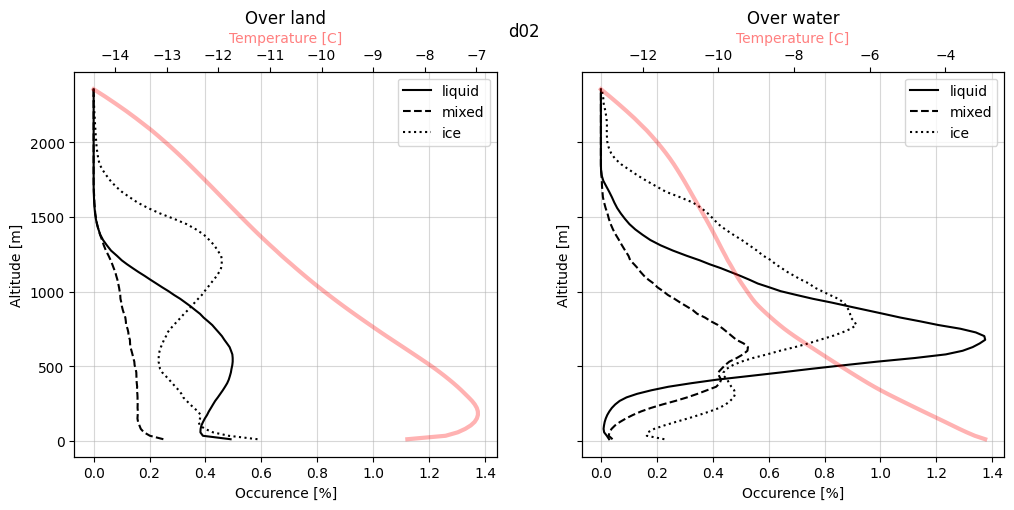

In [95]:
upto = 80
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 5), sharex=True)
h = wrf.getvar(nc.Dataset(Milbrandt2), 'z')[:upto, 10,10]
ax[0].grid(alpha=0.5)
ax[1].grid(alpha=0.5)

axT = ax[0].twiny()
T_mean = (T * LANDMASK).isel(bottom_top=slice(0, upto)).mean(dim=['west_east', 'south_north', 'Time'])
axT.plot(T_mean, h, label='Lapse rate', color='r', alpha=0.3, linewidth=3)
axT.set_xlabel('Temperature [C]', color='red', alpha=0.5)

ax[0].plot((LIQUID*LANDMASK).isel(bottom_top=slice(0, upto)).sum(dim=['Time', 'west_east', 'south_north'])/TNO_L*100, h, c='k', label='liquid')
ax[0].plot((MIXED*LANDMASK).isel(bottom_top=slice(0, upto)).sum(dim=['Time', 'west_east', 'south_north'])/TNO_L*100,  h, c='k', linestyle='dashed', label='mixed')
ax[0].plot((ICE*LANDMASK).isel(bottom_top=slice(0, upto)).sum(dim=['Time', 'west_east', 'south_north'])/TNO_L*100, h, c='k', linestyle='dotted', label='ice')
ax[0].set_xlabel('Occurence [%]')
ax[0].set_ylabel('Altitude [m]')
ax[0].set_title('Over land')


axT = ax[1].twiny()
T_mean = (T*WATERMASK).isel(bottom_top=slice(0, upto)).mean(dim=['west_east', 'south_north', 'Time'])
axT.plot(T_mean, h, label='Lapse rate', color='r', alpha=0.3, linewidth=3)
axT.set_xlabel('Temperature [C]', color='red', alpha=0.5)

ax[1].plot((LIQUID*WATERMASK).isel(bottom_top=slice(0, upto)).sum(dim=['Time', 'west_east', 'south_north'])/TNO_L*100,  h, c='k', label='liquid')
ax[1].plot((MIXED*WATERMASK).isel(bottom_top=slice(0, upto)).sum(dim=['Time', 'west_east', 'south_north'])/TNO_L*100,  h, c='k', linestyle='dashed', label='mixed')
ax[1].plot((ICE*WATERMASK).isel(bottom_top=slice(0, upto)).sum(dim=['Time', 'west_east', 'south_north'])/TNO_L*100,  h, c='k', linestyle='dotted', label='ice')
ax[1].set_xlabel('Occurence [%]')
ax[1].set_ylabel('Altitude [m]')
ax[1].set_title('Over water')
ax[0].legend(loc='upper right')
ax[1].legend(loc='upper right')
fig.suptitle(domain)
plt.show()

del T_mean, h, fig, ax, axT

## Clustering

In [20]:
#MIXED_test = MIXED.isel(Time=99, south_north=50)
#LIQUID_test = LIQUID.isel(Time=99, south_north=50)
#ICE_test = ICE.isel(Time=99, south_north=50)

In [21]:
#MIXED_test_points = np.where(MIXED_test.to_numpy() == 1)
#MIXED_test_points = np.column_stack([MIXED_test_points[0], MIXED_test_points[1]])

In [22]:
#clusters = cluster.DBSCAN(eps=5)

In [23]:
#labels = clusters.fit_predict(MIXED_test_points)

In [24]:
#plt.scatter(MIXED_test_points[:,1], MIXED_test_points[:,0], c=labels)

# Cloud top

Temp, W, ICNC - one only QICE, then plus snow and graupel, TWC

Weighted mean for IWF based on TWC [How does that work when Liquid is already 0? How to weight zeros?]

### CT plots

In [3]:
CLOUDTOP = find_top(MD3, MorrisonDefault3, cld_thrsh=0.5, t=slice(0, -1))

In [5]:
IWF_TOP = select_top(iwf_calc(MD3, mass=True, t=slice(0, -1)), CLOUDTOP, n_levels=10).mean(dim=['bottom_top'])
T_TOP = select_top(calc_T(MD3, t=slice(0, -1)), CLOUDTOP, n_levels=10).mean(dim=['bottom_top'])
W_TOP = select_top(calc_W(MD3, t=slice(0, -1)), CLOUDTOP, n_levels=10).mean(dim=['bottom_top'])

In [7]:
def plot_CT(t, data=Mil3):
    CLOUDTOP = find_top(MD3, MorrisonDefault3, cld_thrsh=0.5, t=slice(0, -1))
    IWF_TOP = select_top(iwf_calc(MD3, mass=True, t=slice(0, -1)), CLOUDTOP, n_levels=10).mean(dim=['bottom_top'])
    T_TOP = select_top(calc_T(MD3, t=slice(0, -1)), CLOUDTOP, n_levels=10).mean(dim=['bottom_top'])
    W_TOP = select_top(calc_W(MD3, t=slice(0, -1)), CLOUDTOP, n_levels=10).mean(dim=['bottom_top'])

    proj = ccrs.NorthPolarStereo(11.1)
    fig, ax = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(14, 5), subplot_kw={'projection':proj})
    time = data.XTIME.isel(Time=t).dt.strftime('%y-%m-%d %H:%M').to_numpy()
    fig.suptitle(f'Cloud-top {domain}, upper 10, t={time}')

    
    IWF_TOP.isel(Time=t).plot(x='XLONG', y='XLAT', transform=ccrs.PlateCarree(), ax=ax[0], 
    levels=np.arange(0, 1.11, 0.1), cmap='coolwarm', 
    cbar_kwargs={'label': 'Fraction', 'orientation': 'horizontal'})
    ax[0].set_title(f'Cloud-top Ice Water Fraction')

    T_TOP.isel(Time=t).plot(x='XLONG', y='XLAT', transform=ccrs.PlateCarree(), ax=ax[1], 
    levels=np.arange(-16, -7, 1), cmap='coolwarm',
    cbar_kwargs={'label': 'deg C', 'orientation': 'horizontal'})
    ax[1].set_title(f'Cloud-top Temperature')

    h = select_top(wrf.getvar(nc.Dataset(Milbrandt3), 'z'), 
                   CLOUDTOP.isel(Time=t), n_levels=1).sum(dim='bottom_top')
    h.plot(x='XLONG', y='XLAT', transform=ccrs.PlateCarree(), ax=ax[2], 
    levels=[5] + list(np.arange(250, 2250, 250)), cmap='viridis', extend='max',
    cbar_kwargs={'label': 'm', 'orientation': 'horizontal'})
    ax[2].set_title(f'Cloud-top height')

    (W_TOP.isel(Time=t) * 100).plot(x='XLONG', y='XLAT', transform=ccrs.PlateCarree(), ax=ax[3], extend='both',
    levels=np.arange(-45, 50, 10), cmap='bwr', cbar_kwargs={'label': 'cm/s', 'orientation': 'horizontal'})
    ax[3].set_title(f'Cloud-top Updraft')
    plt.tight_layout()

    for x in ax:
        x.coastlines()
        x.gridlines()
        x.scatter(y=78.923538, x=11.909895, transform=ccrs.PlateCarree(), linewidth=3, color='k', marker='x')


    return fig

In [8]:
plot_CT(t=1)
plt.show()

ValueError: operands could not be broadcast together with shapes (231,84,90,90) (84,100,100) 

In [18]:
animate(plot_CT, data=MD3, anim_title='MorrisonDefault_CTAnimation', n_timesteps=230)

100%|██████████| 230/230 [05:19<00:00,  1.39s/it]


### CT Stats

In [14]:
_IWF_TOP = select_top(IWF, CLOUDTOP, n_levels=10).isel(Time=slice(0, 100))
print('Cloud Top stats BEFORE t=12/11 13:00')
print_stats(
    xr.where(_IWF_TOP > 0.95, x=_IWF_TOP, y=np.nan), 
    xr.where((_IWF_TOP < 0.95) 
    & (_IWF_TOP > 0.05), x=_IWF_TOP, y=np.nan), 
    xr.where(_IWF_TOP < 0.05, x=_IWF_TOP, y=np.nan),
    _IWF_TOP)


print('--------------------------')
_IWF_TOP = select_top(IWF, CLOUDTOP, n_levels=10).isel(Time=slice(100, -1))
print('Cloud Top stats AFTER t=12/11 13:00')
print_stats(
    xr.where(_IWF_TOP > 0.95, x=_IWF_TOP, y=np.nan), 
    xr.where((_IWF_TOP < 0.95) 
    & (_IWF_TOP > 0.05), x=_IWF_TOP, y=np.nan), 
    xr.where(_IWF_TOP < 0.05, x=_IWF_TOP, y=np.nan),
    _IWF_TOP)
del _IWF_TOP

Cloud Top stats BEFORE t=12/11 14:00
Over land:
Ice:  733723 ,  15.97 %
Mixed:  771701 ,  16.79 %
Liquid:  3090199 ,  67.24 %
Over water:
Ice:  612846 ,  11.85 %
Mixed:  287870 ,  5.57 %
Liquid:  4270488 ,  82.58 %
--------------------------
Cloud Top stats AFTER t=12/11 14:00
Over land:
Ice:  3407818 ,  55.89 %
Mixed:  1108992 ,  18.19 %
Liquid:  1580322 ,  25.92 %
Over water:
Ice:  5583377 ,  87.88 %
Mixed:  192833 ,  3.04 %
Liquid:  576878 ,  9.08 %


In [15]:
def calc_precentages(iwf):
    ice = float(xr.where(iwf > 0.95, x=1, y=np.nan).count() / (iwf).count()) * 100
    mixed = float(xr.where((iwf < 0.95) & (iwf > 0.05), x=1, y=np.nan).count() / (iwf).count()) * 100
    liquid = float(xr.where(iwf < 0.05, x=1, y=np.nan).count() / (iwf).count()) * 100
    return [liquid, mixed, ice]

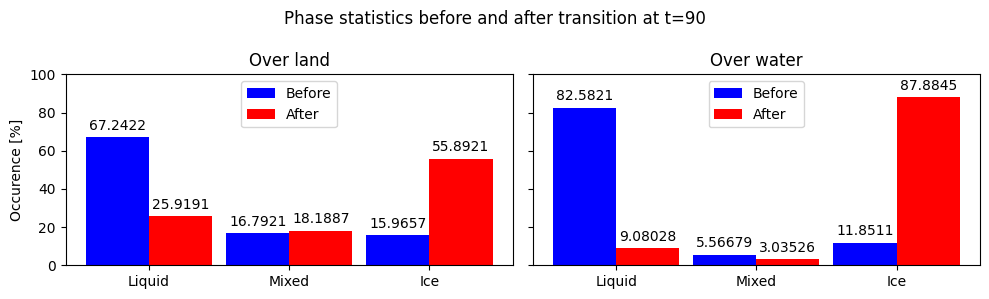

In [16]:
t_split = 100

x = np.array([1, 2, 3])
width = 0.45

IWF_TOP = select_top(IWF, CLOUDTOP, n_levels=10)

fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharex=True, sharey=True)
rects1 = ax[0].bar(x - width/2, calc_precentages(IWF_TOP.isel(Time=slice(0, t_split)) * LANDMASK), width, label='Before', color='blue')
rects2 = ax[0].bar(x + width/2, calc_precentages(IWF_TOP.isel(Time=slice(t_split, -1)) * LANDMASK), width, label='After', color='red')

ax[0].set_ylabel('Occurence [%]')
ax[0].set_title('Over land')
ax[0].set_xticks(x, ['Liquid', 'Mixed', 'Ice'])
ax[0].legend(loc='upper center')

ax[0].bar_label(rects1, padding=3)
ax[0].bar_label(rects2, padding=3)

rects1 = ax[1].bar(x - width/2, calc_precentages(IWF_TOP.isel(Time=slice(0, t_split)) * WATERMASK), width, label='Before', color='blue')
rects2 = ax[1].bar(x + width/2, calc_precentages(IWF_TOP.isel(Time=slice(t_split, -1)) * WATERMASK), width, label='After', color='red')
ax[1].set_ylim(0, 100)
ax[1].set_title('Over water')
ax[1].set_xticks(x, ['Liquid', 'Mixed', 'Ice'])
ax[1].legend(loc='upper center')

ax[1].bar_label(rects1, padding=3)
ax[1].bar_label(rects2, padding=3)


fig.suptitle('Phase statistics before and after transition at t=90')
fig.tight_layout()
plt.show()
del IWF_TOP

### CT Histograms and PDF

NameError: name 'CLOUDTOP' is not defined

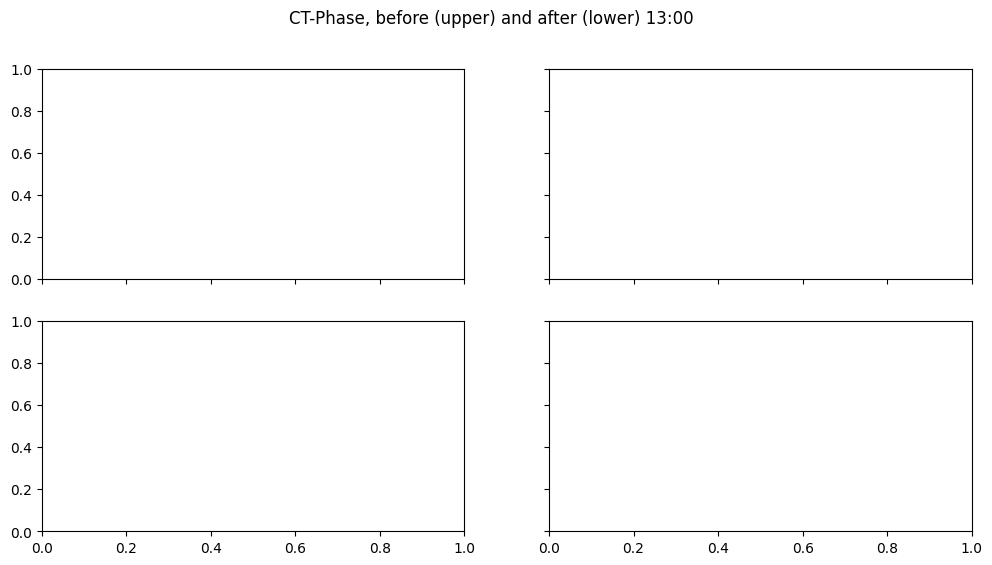

In [207]:
def hist_plot(mean=True, density=False):
    bins = np.arange(start=-15, stop=0, step=0.1)

    fig, ax = plt.subplots(2, 2, figsize=(12,6), sharey=True, sharex=True)
    fig.suptitle('CT-Phase, before (upper) and after (lower) 13:00')

    ################# Before
    time_slice = slice(0, 100)

    # Without mean:
    IWF_TOP = select_top(IWF, CLOUDTOP, n_levels=10).isel(Time=time_slice)
    T_TOP = select_top(T, CLOUDTOP, n_levels=10).isel(Time=time_slice)

    if mean:
        IWF_TOP = IWF_TOP.mean(dim='bottom_top')
        T_TOP = T_TOP.mean(dim='bottom_top')
        fig.suptitle('CT-Phase (mean), before (upper) and after (lower) 13:00')

    MIXED_TOP = xr.where((IWF_TOP > 0.05) & (IWF_TOP < 0.95), x=1, y=np.nan)
    ax[0, 0].hist((MIXED_TOP * LANDMASK * T_TOP).to_numpy().ravel(),
                    alpha=1, density=density, label='mixed', edgecolor='k', color='g', bins=bins)
    ax[0, 1].hist((MIXED_TOP * WATERMASK * T_TOP).to_numpy().ravel(), 
                    alpha=1, density=density, label='mixed', edgecolor='k', color='g', bins=bins)
    del MIXED_TOP

    LIQUID_TOP = xr.where(IWF_TOP < 0.05, x=1, y=np.nan)
    ax[0, 0].hist((LIQUID_TOP * LANDMASK * T_TOP).to_numpy().ravel(), 
                    alpha=0.5, density=density, label='liquid', edgecolor='k', color='#00008B', bins=bins)
    ax[0, 1].hist((LIQUID_TOP * WATERMASK * T_TOP).to_numpy().ravel(), 
                    alpha=0.5, density=density, label='liquid', edgecolor='k', color='#00008B', bins=bins)
    del LIQUID_TOP

    ICE_TOP = xr.where(IWF_TOP > 0.95, x=1, y=np.nan)
    ax[0, 0].hist((ICE_TOP * LANDMASK * T_TOP).to_numpy().ravel(), 
                    alpha=0.4, density=density, label='ice', edgecolor='k', color='#ADD8E6', bins=bins)
    ax[0, 1].hist((ICE_TOP * WATERMASK * T_TOP).to_numpy().ravel(), 
                    alpha=0.4, density=density, label='ice', edgecolor='k', color='#ADD8E6', bins=bins)
    del ICE_TOP

    ax[0, 0].set_title('Over land')
    ax[0, 0].set_ylabel('Occurences')
    ax[0, 0].legend()

    ax[0, 1].set_title('Over water')
    ax[0, 1].legend()


    ################# After
    time_slice = slice(100, -1)
    
    IWF_TOP = select_top(IWF, CLOUDTOP, n_levels=10).isel(Time=time_slice)
    T_TOP = select_top(T, CLOUDTOP, n_levels=10).isel(Time=time_slice)
    
    if mean:
        IWF_TOP = IWF_TOP.mean(dim='bottom_top')
        T_TOP = T_TOP.mean(dim='bottom_top')
        fig.suptitle('CT-Phase (mean), before (upper) and after (lower) 13:00')

    MIXED_TOP = xr.where((IWF_TOP > 0.05) & (IWF_TOP < 0.95), x=1, y=np.nan)
    ax[1, 0].hist((MIXED_TOP * LANDMASK * T_TOP).to_numpy().ravel(), 
                    alpha=1, density=density, label='mixed', edgecolor='k', color='g', bins=bins)
    ax[1, 1].hist((MIXED_TOP * WATERMASK * T_TOP).to_numpy().ravel(), 
                    alpha=1, density=density, label='mixed', edgecolor='k', color='g', bins=bins)
    del MIXED_TOP

    LIQUID_TOP = xr.where(IWF_TOP < 0.05, x=1, y=np.nan)
    ax[1, 0].hist((LIQUID_TOP * LANDMASK * T_TOP).to_numpy().ravel(), 
                    alpha=0.5, density=density, label='liquid', edgecolor='k', color='#00008B', bins=bins)
    ax[1, 1].hist((LIQUID_TOP * WATERMASK * T_TOP).to_numpy().ravel(), 
                    alpha=0.5, density=density, label='liquid', edgecolor='k', color='#00008B', bins=bins)
    del LIQUID_TOP

    ICE_TOP = xr.where(IWF_TOP > 0.95, x=1, y=np.nan)
    ax[1, 0].hist((ICE_TOP * LANDMASK * T_TOP).to_numpy().ravel(), 
                    alpha=0.4, density=density, label='ice', edgecolor='k', color='#ADD8E6', bins=bins)
    ax[1, 1].hist((ICE_TOP * WATERMASK * T_TOP).to_numpy().ravel(), 
                    alpha=0.4, density=density, label='ice', edgecolor='k', color='#ADD8E6', bins=bins)
    del ICE_TOP

    ax[1, 0].set_xlabel('Temperature (C)')
    ax[1, 0].set_ylabel('Occurences')
    ax[1, 0].legend()

    ax[1, 1].set_xlabel('Temperature (C)')
    ax[1, 1].legend()

    plt.show()
    del IWF_TOP, T_TOP
hist_plot(mean=False, density=True)

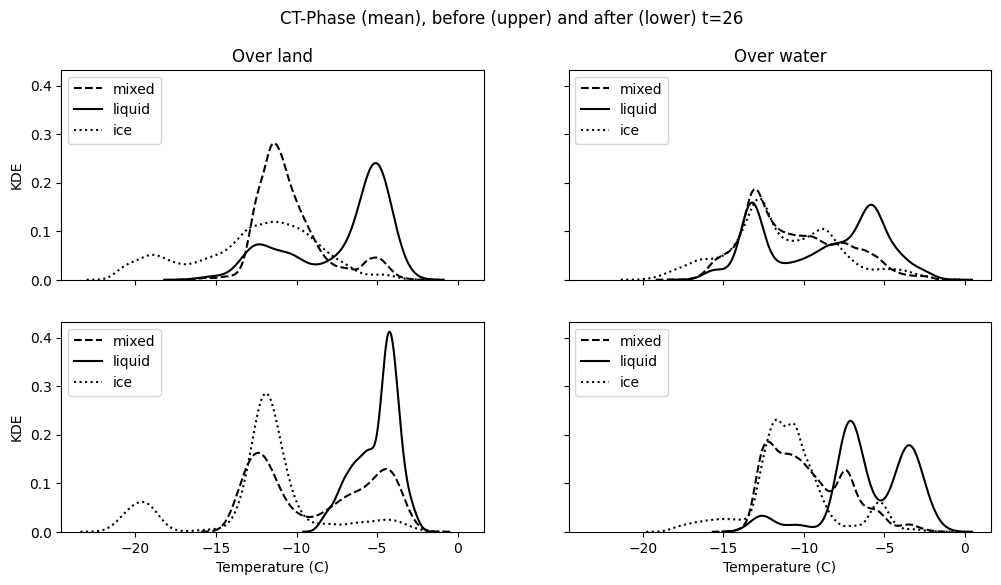

In [207]:
def KDE_plot(mean=True):
    bins = np.arange(start=-15, stop=0, step=0.1)

    fig, ax = plt.subplots(2, 2, figsize=(12,6), sharey=True, sharex=True)
    fig.suptitle('CT-Phase, before (upper) and after (lower) t=26')

    ################# Before
    time_slice = slice(0, 26)
    IWF_TOP = select_top(IWF, CLOUDTOP, n_levels=10).isel(Time=time_slice)
    T_TOP = select_top(T, CLOUDTOP, n_levels=10).isel(Time=time_slice)

    if mean:
        IWF_TOP = IWF_TOP.mean(dim='bottom_top')
        T_TOP = T_TOP.mean(dim='bottom_top')
        fig.suptitle('CT-Phase (mean), before (upper) and after (lower) t=26')

    MIXED_TOP = (xr.where((IWF_TOP > 0.05) & (IWF_TOP < 0.95), x=1, y=np.nan) * LANDMASK * T_TOP).to_numpy().ravel()
    sns.kdeplot(MIXED_TOP[~np.isnan(MIXED_TOP)], ax=ax[0,0], color='k', linestyle='dashed', label='mixed')
    MIXED_TOP = (xr.where((IWF_TOP > 0.05) & (IWF_TOP < 0.95), x=1, y=np.nan) * WATERMASK * T_TOP).to_numpy().ravel()
    sns.kdeplot(MIXED_TOP[~np.isnan(MIXED_TOP)], ax=ax[0,1], color='k', linestyle='dashed', label='mixed')
    del MIXED_TOP

    LIQUID_TOP = (xr.where(IWF_TOP < 0.05, x=1, y=np.nan) * LANDMASK * T_TOP).to_numpy().ravel()
    sns.kdeplot(LIQUID_TOP[~np.isnan(LIQUID_TOP)], ax=ax[0,0], color='k', linestyle='solid', label='liquid')
    LIQUID_TOP = (xr.where(IWF_TOP < 0.05, x=1, y=np.nan) * WATERMASK * T_TOP).to_numpy().ravel()
    sns.kdeplot(LIQUID_TOP[~np.isnan(LIQUID_TOP)], ax=ax[0,1], color='k', linestyle='solid', label='liquid')
    del LIQUID_TOP

    ICE_TOP = (xr.where(IWF_TOP > 0.95, x=1, y=np.nan) * LANDMASK * T_TOP).to_numpy().ravel()
    sns.kdeplot(ICE_TOP[~np.isnan(ICE_TOP)], ax=ax[0,0], color='k', linestyle='dotted', label='ice')
    ICE_TOP = (xr.where(IWF_TOP > 0.95, x=1, y=np.nan) * WATERMASK * T_TOP).to_numpy().ravel()
    sns.kdeplot(ICE_TOP[~np.isnan(ICE_TOP)], ax=ax[0,1], color='k', linestyle='dotted', label='ice')
    del ICE_TOP


    ################# After
    time_slice = slice(26, -1)

    IWF_TOP = select_top(IWF, CLOUDTOP, n_levels=10).isel(Time=time_slice)
    T_TOP = select_top(T, CLOUDTOP, n_levels=10).isel(Time=time_slice)
    if mean:
        IWF_TOP = IWF_TOP.mean(dim='bottom_top')
        T_TOP = T_TOP.mean(dim='bottom_top')

    MIXED_TOP = (xr.where((IWF_TOP > 0.05) & (IWF_TOP < 0.95), x=1, y=np.nan) * LANDMASK * T_TOP).to_numpy().ravel()
    sns.kdeplot(MIXED_TOP[~np.isnan(MIXED_TOP)], ax=ax[1,0], color='k', linestyle='dashed', label='mixed')
    MIXED_TOP = (xr.where((IWF_TOP > 0.05) & (IWF_TOP < 0.95), x=1, y=np.nan) * WATERMASK * T_TOP).to_numpy().ravel()
    sns.kdeplot(MIXED_TOP[~np.isnan(MIXED_TOP)], ax=ax[1,1], color='k', linestyle='dashed', label='mixed')
    del MIXED_TOP

    LIQUID_TOP = (xr.where(IWF_TOP < 0.05, x=1, y=np.nan) * LANDMASK * T_TOP).to_numpy().ravel()
    sns.kdeplot(LIQUID_TOP[~np.isnan(LIQUID_TOP)], ax=ax[1,0], color='k', linestyle='solid', label='liquid')
    LIQUID_TOP = (xr.where(IWF_TOP < 0.05, x=1, y=np.nan) * WATERMASK * T_TOP).to_numpy().ravel()
    sns.kdeplot(LIQUID_TOP[~np.isnan(LIQUID_TOP)], ax=ax[1,1], color='k', linestyle='solid', label='liquid')
    del LIQUID_TOP

    ICE_TOP = (xr.where(IWF_TOP > 0.95, x=1, y=np.nan) * LANDMASK * T_TOP).to_numpy().ravel()
    sns.kdeplot(ICE_TOP[~np.isnan(ICE_TOP)], ax=ax[1,0], color='k', linestyle='dotted', label='ice')
    ICE_TOP = (xr.where(IWF_TOP > 0.95, x=1, y=np.nan) * WATERMASK * T_TOP).to_numpy().ravel()
    sns.kdeplot(ICE_TOP[~np.isnan(ICE_TOP)], ax=ax[1,1], color='k', linestyle='dotted', label='ice')
    del ICE_TOP

    ax[1, 1].set_xlabel('Temperature (C)')
    ax[1, 0].set_xlabel('Temperature (C)')
    ax[0, 0].set_ylabel('KDE')
    ax[1, 0].set_ylabel('KDE')
    ax[0, 0].legend(loc='upper left'); ax[1, 0].legend(loc='upper left')
    ax[1, 1].legend(loc='upper left'); ax[0, 1].legend(loc='upper left')
    ax[0, 0].set_title('Over land')
    ax[0, 1].set_title('Over water')

    plt.show()
KDE_plot(mean=True)

### CT Temporal phase segments

In [21]:
Mil2C = clip_to_region(Mil2, Milbrandt2, clip_to_data=Milbrandt3)

In [4]:
IWF = select_top(iwf_calc(MD3, mass=True, cld_thrsh=0.5), 
                 find_top(MD3, MorrisonDefault3, cld_thrsh=0.5), 
                 n_levels=7).mean(dim='bottom_top')
IWF_masked = xr.where(IWF > 0.9, x = 1, y = IWF)
IWF_masked = xr.where(IWF_masked <= 0.1, x = 0, y = IWF_masked)
IWF_masked = xr.where((IWF_masked > 0.1) & (IWF_masked < 0.9), x = 0.5, y = IWF_masked)

#CTL = find_top(Mil3, Milbrandt3, cld_thrsh=0.5)
#wind = wrf.getvar(nc.Dataset(Milbrandt3), "wspd", units="m s-1", timeidx=wrf.ALL_TIMES)

In [28]:
#IWF_maskedC = clip_to_region(IWF_masked, Milbrandt2, clip_to_data=Milbrandt3)
#CTLC = clip_to_region(CTL, Milbrandt2, clip_to_data=Milbrandt3)
#windC = clip_to_region(wind, Milbrandt2, clip_to_data=Milbrandt3)

In [3]:
import time
class timer:
    def __init__(self):
        self._start_time = None
        self._round_time = None

    def start(self):
        self._start_time = time.perf_counter()

    def round(self):
        if self._round_time is None:
            t = time.perf_counter() - self._start_time
            self._round_time = time.perf_counter()
        else:
            t = time.perf_counter() - self._round_time
            self._round_time = time.perf_counter()
        return f'Elapsed time: {t:0.4f} seconds'
    
    def stop(self):
        t = time.perf_counter() - self._start_time
        self._start_time = None
        self._round_time = None
        return f'Elapsed time: {t:0.4f} seconds.'


In [129]:
def consecutive(arr):
    return np.split(arr, np.where(np.diff(arr) != 1)[0] + 1)


def segment_lengths(data, datapath, n_points=None, condition='IWF > 0.5', mass=True, 
                    n_levels=7, cld_thrsh=0.5, IWF_masked=None, CTL=None, winds=None, 
                    from_time=0, to_time=None, coarsen=False, custom=False):
    '''Find length of consecutive phase segements'''

    #if wind is None:
    #    print('Getting wind')
    #    wind = wrf.getvar(nc.Dataset(datapath), "wspd", units="m s-1", 
    #                      timeidx=wrf.ALL_TIMES).isel(Time=slice(from_time, to_time))
    #    print('Done')
    #else:
    #    wind = wind.isel(Time=slice(from_time, to_time))
    

    if not custom:
        t = timer()
        t.start()
        if CTL is None:
            print('Getting Cloud-Top...')
            CTL = find_top(data, datapath, cld_thrsh=cld_thrsh, t=slice(from_time, to_time))
            print(f'Done. {t.round()}')
        else:
            CTL = CTL.isel(Time=slice(from_time, to_time))
        

        if IWF_masked is None:
            print('Getting IWF...')
            IWF_masked = select_top(iwf_calc(data, mass=mass, cld_thrsh=cld_thrsh, t=slice(from_time, to_time)), 
                                    find_top(data, datapath, cld_thrsh=cld_thrsh, t=slice(from_time, to_time)), 
                                    n_levels=n_levels).mean(dim='bottom_top')
            
            if coarsen:
                IWF_masked = IWF_masked.coarsen(Time=12, boundary='trim').mean()

            IWF_masked = xr.where(IWF_masked > 0.9, x = 1, y = IWF_masked)
            IWF_masked = xr.where(IWF_masked <= 0.1, x = 0, y = IWF_masked)
            IWF_masked = xr.where((IWF_masked > 0.1) & (IWF_masked < 0.9), x = 0.5, y = IWF_masked)
            print(f'Done. {t.round()}')
        else:
            IWF_masked = IWF_masked.isel(Time=slice(from_time, to_time))


        x_shape, y_shape = len(data.west_east), len(data.south_north)
        if n_points is None:
            n_points = x_shape * y_shape
        
        if winds is None:
            print('Getting wind...')
            step = [1 if not coarsen else 12][0]
            if domain == 'd02':
                winds = [wrf.getvar(nc.Dataset(datapath), "wspd", 
                                    units="m s-1", timeidx=t) for t in range(12, 12 + len(IWF_masked.Time))]
            else:
                winds = [wrf.getvar(nc.Dataset(datapath), "wspd", 
                                    units="m s-1", timeidx=t) for t in range(144, 144 + len(data.Time), step)]
            
            print(f'Done. {t.round()}')
    else:
        x_shape, y_shape = len(IWF_masked.west_east), len(IWF_masked.south_north)
        if n_points is None:
            n_points = x_shape * y_shape

    time_res_sec = int((IWF_masked.XTIME.isel(Time=1) - IWF_masked.XTIME.isel(Time=0)).to_numpy())/1000000000

    def f(i):
        x, y = int(np.floor(i / x_shape)), int(i % y_shape) #translate to x, y

        xy_IWF = IWF_masked.isel(south_north=y, west_east=x)
        P = np.where(eval('xy_IWF' + condition))[0]
        segment = consecutive(P)
        
        LENGTHS = []
        WSPD = 0
        for e in segment:
            length = 0
            wind = 0
            for timeidx in e:
                H = int(CTL.isel(Time=timeidx, south_north=y, west_east=x))
                wspd = float(winds[timeidx].isel(bottom_top=H, south_north=y, west_east=x))
                length += wspd * time_res_sec / 1000 # m/s * resolution in seconds /1000= km
                wind += wspd / len(e)
            LENGTHS.append(length)
            WSPD += wind / len(segment)

        #print(np.array(LENGTHS), np.array(LENGTHS).mean(), WSPD)
        return np.array(LENGTHS), WSPD

    #set_loky_pickler('multithreading')
    with tqdm_joblib('Progress', total=n_points) as progress_bar:
        res = Parallel(n_jobs=32, backend='threading')(delayed(f)(i) for i in range(n_points))

    #res = [f(i) for i in range(n_points)]

    # Create data set of mean lengths, total lengths
    DA_mean = np.zeros((x_shape, y_shape))
    DA_total = np.zeros((x_shape, y_shape))
    DA_nsegments = np.zeros((x_shape, y_shape))
    DA_winds = np.zeros((x_shape, y_shape))

    for i in range(n_points):
        x, y = int(np.floor(i / x_shape)), int(i % y_shape)
        length, windspeeds = res[i]
        DA_mean[x, y] = length.mean()
        DA_total[x, y] = length.sum()
        DA_nsegments[x, y] = len(length)
        DA_winds[x, y] = windspeeds

    if condition[0] == '=':
        description = 'Mixed-phase segment stats'
    else:
        description = ['Liquid segment stats' if condition[0] == '<' else 'Ice segment stats']
    
    DA = xr.Dataset(data_vars=dict(
            MEAN = (['west_east', 'south_north'], DA_mean),
            TOTAL = (['west_east', 'south_north'], DA_total),
            N_SEGMENTS = (['west_east', 'south_north'], DA_nsegments),
            WSPD = (['west_east', 'south_north'], DA_winds)
        ),
        attrs = dict(
            description=description, units='m', 
            #start = data.XTIME.isel(Time=from_time).dt.strftime('%y-%m-%d %H:%M').to_numpy(),
            #end = data.XTIME.isel(Time=to_time).dt.strftime('%y-%m-%d %H:%M').to_numpy()
            start = datetime(year=2019, month=11, day=12, hour=4, minute=40),
            end = datetime(year=2019, month=11, day=12, hour=23, minute=0)
        )
    )

    DA.coords['lon'] = IWF_masked.XLONG.isel(Time=0)
    DA.coords['lat'] = IWF_masked.XLAT.isel(Time=0)
    
    return res, DA #calculations

In [99]:
datapath = get_datapaths(2)
data = convert(datapath, dom='d03')
print('Getting Cloud-Top...')
CTL = find_top(data, 
    datapath, 
    cld_thrsh=0.5, 
    t=slice(None, None)).isel(
        west_east=slice(0, -1), 
        south_north=slice(0, -1)).coarsen(
            west_east=5, 
            south_north=5, 
            Time=12,
            boundary='trim').mean()
print('Getting IWF...')
ICE = all_ice(data).isel(
        west_east=slice(0, -1), 
        south_north=slice(0, -1)).coarsen(
            west_east=5, 
            south_north=5, 
            Time=12,
            boundary='trim').mean()
LIQUID = all_liquid(data).isel(
        west_east=slice(0, -1), 
        south_north=slice(0, -1)).coarsen(
            west_east=5, 
            south_north=5, 
            Time=12,
            boundary='trim').mean()
IWF_masked = select_top(ICE / (ICE + LIQUID), CTL, n_levels=7).mean(dim='bottom_top')
IWF_masked = xr.where(IWF_masked > 0.9, x = 1, y = IWF_masked)
IWF_masked = xr.where(IWF_masked <= 0.1, x = 0, y = IWF_masked)
IWF_masked = xr.where((IWF_masked > 0.1) & (IWF_masked < 0.9), x = 0.5, y = IWF_masked)
print('Getting winds...')
winds = [wrf.getvar(nc.Dataset(datapath), 
        "wspd", 
        units="m s-1", 
        timeidx=t).isel(west_east=slice(0, -1), 
                        south_north=slice(0, -1)).coarsen(west_east=5, 
                                                          south_north=5, 
                                                          boundary='trim').mean() for t in range(0, 24*5, 5)]
_, DAC = segment_lengths(data, datapath, n_points=None, 
                                  condition='== 0.5', cld_thrsh=0.5, custom=True,
                                  IWF_masked=IWF_masked, CTL=CTL, winds=winds)

Calculating density
------------------------------------------------------
Converting units kg/kg -> g/m3


Dataset 1/1: 100%|██████████| 6/6 [00:42<00:00,  7.10s/it]


Getting Cloud-Top...
Getting IWF...
Getting winds...


  0%|          | 0/361 [00:00<?, ?it/s]

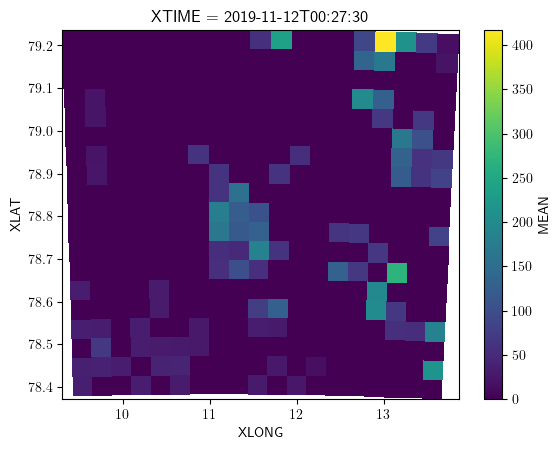

In [100]:
DAC.MEAN.plot(x='XLONG', y='XLAT')

In [101]:
store(DAC, files3coarsenedBefore[2])

In [130]:
MAS3_res, MAS3_DA = segment_lengths(MAS3, MorrisonAdaptedSIP3, n_points=None, 
                                  condition='== 0.5', cld_thrsh=0.5, coarsen=True)

Getting Cloud-Top...
Done. Elapsed time: 3.1148 seconds
Getting IWF...
Done. Elapsed time: 9.2139 seconds
Getting wind...
Done. Elapsed time: 8.9421 seconds


  0%|          | 0/10000 [00:00<?, ?it/s]

In [22]:
store(MAS3_DA, files3[3])

In [134]:
MAS3_DAC = MAS3_DA.isel(west_east=slice(0, -1), 
                        south_north=slice(0, -1)).coarsen(west_east=5, 
                                                          south_north=5, 
                                                          boundary='trim').mean()
store(MAS3_DAC, files3coarsened[3])

In [26]:
MDS2_DAC = clip_to_region(MDS2_DA, MorrisonDefaultSIP2, clip_to_data=MorrisonDefault3)
store(MDS2_DAC, files2clipped[1])

In [88]:
files3 = [
    'analysis_data/temporal_segments/MorrisonDefault3_MixedTemporalSegmentsMass',
    'analysis_data/temporal_segments/MorrisonDefaultSIP3_MixedTemporalSegmentsMass',
    'analysis_data/temporal_segments/MorrisonAdapted3_MixedTemporalSegmentsMass',
    'analysis_data/temporal_segments/MorrisonAdaptedSIP3_MixedTemporalSegmentsMass'
    ]
files3coarsened = [
    'analysis_data/temporal_segments/MorrisonDefault3_MixedTemporalSegmentsMass_coarsened',
    'analysis_data/temporal_segments/MorrisonDefaultSIP3_MixedTemporalSegmentsMass_coarsened',
    'analysis_data/temporal_segments/MorrisonAdapted3_MixedTemporalSegmentsMass_coarsened',
    'analysis_data/temporal_segments/MorrisonAdaptedSIP3_MixedTemporalSegmentsMass_coarsened'
    ]
files3coarsenedBefore = [
    'analysis_data/temporal_segments/MorrisonDefault3_MixedTemporalSegmentsMass_coarsenedBefore',
    'analysis_data/temporal_segments/MorrisonDefaultSIP3_MixedTemporalSegmentsMass_coarsenedBefore',
    'analysis_data/temporal_segments/MorrisonAdapted3_MixedTemporalSegmentsMass_coarsenedBefore',
    'analysis_data/temporal_segments/MorrisonAdaptedSIP3_MixedTemporalSegmentsMass_coarsenedBefore'
    ]
files2clipped = [
    'analysis_data/temporal_segments/MorrisonDefault2_MixedTemporalSegmentsMass_clipped',
    'analysis_data/temporal_segments/MorrisonDefaultSIP2_MixedTemporalSegmentsMass_clipped',
    'analysis_data/temporal_segments/MorrisonAdapted2_MixedTemporalSegmentsMass_clipped',
    'analysis_data/temporal_segments/MorrisonAdaptedSIP2_MixedTemporalSegmentsMass_clipped'
    ]

### Absolute

In [3]:
IWF = []
for i in tqdm.tqdm(range(4)):

    data3 = xr.open_dataset(d3[i]).isel(Time=slice(144, None),
                                        bottom_top=slice(None, 85),
                                        bottom_top_stag=slice(None, 85))

    IWFTOP3 = select_top(
        iwf_calc(data3), cloudtop=find_top(data3, d3[i], cld_thrsh=0.5)
        ).mean(dim=['Time', 'bottom_top'])
    
    del data3
    IWF.append(IWFTOP3)
    del IWFTOP3

100%|██████████| 4/4 [06:46<00:00, 101.63s/it]


In [6]:
datas = []
for file in files3:
    datas.append(load(file))

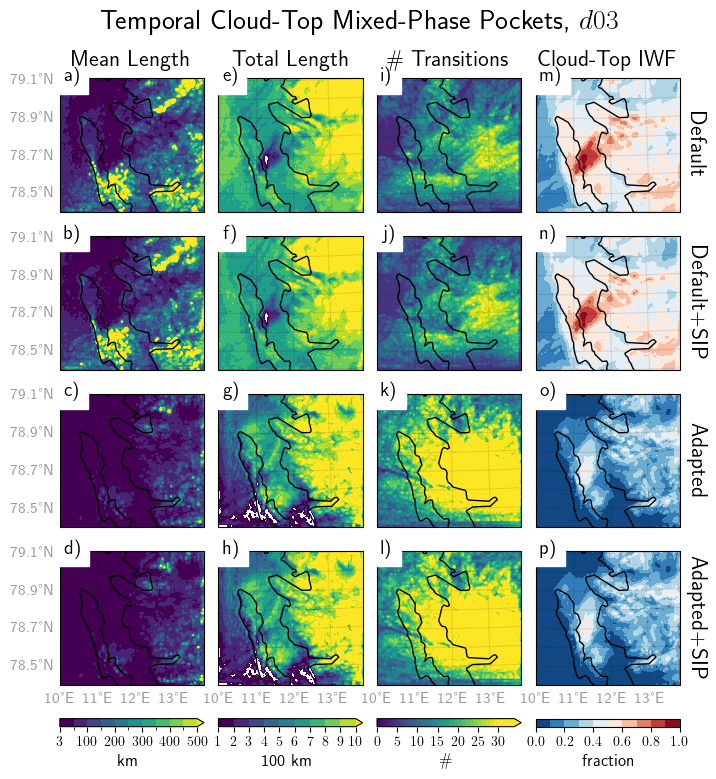

In [29]:
proj = ccrs.NorthPolarStereo(11.11)
fig, axs = plt.subplots(4, 4, figsize=(8, 8), subplot_kw={'projection': proj})

dl1 = list(np.arange(-4, -0.9, 1)) + list(np.arange(1, 4.1, 1))

levels = [[3] + list(np.arange(50, 501, 50)), 
          [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
              np.arange(0, 35, 1), 
              np.arange(0, 1.1, 0.1)]



norm = TwoSlopeNorm(vcenter=0)

for i, ax_col, data, iwf in zip(range(4), axs, datas, IWF):

    p1 = (data.MEAN).plot.contourf(x='lon', y='lat', transform=ccrs.PlateCarree(), vmin=0, vmax=500,
            ax=ax_col[0], levels=levels[0], add_colorbar=False, extend='max', antialiased=False)
    
    p2 = (data.TOTAL/100).plot.contourf(x='lon', y='lat', transform=ccrs.PlateCarree(),
            ax=ax_col[1], levels=levels[1], add_colorbar=False, extend='max', antialiased=False)
    

    p3 = ax_col[2].contourf(data.lon, data.lat, data.N_SEGMENTS, levels=levels[2], extend='max',
                            vmin=0, vmax=30, transform=ccrs.PlateCarree(), antialiased=False)

    #p3 = (data.N_SEGMENTS).plot.contourf(x='lon', y='lat', transform=ccrs.PlateCarree(),
    #        ax=ax_col[2], add_colorbar=False, levels=levels[2], vmin=0, vmax=10, antialiased=False)
    
  
    p4 = ax_col[3].contourf(data.lon, data.lat, iwf, cmap='RdBu_r', levels=levels[3],
                            antialiased=False, transform=ccrs.PlateCarree())

[x.set_title(None) and x.coastlines() for x in axs.flatten()]

for i, x in enumerate(axs.T.ravel()):
    x.set_extent([10, 13.8, 78.4, 79.1], crs=ccrs.PlateCarree())
    x.text(x=0.03, y=0.98, s=get_subplot_label(i), transform=x.transAxes, backgroundcolor='white',
           fontsize=14)

# Colorbars
cbar_ax = inset_axes(axs[3, 0], width='100%', height='6%', loc='lower center', borderpad=-3)
cb1 = plt.colorbar(p1, cbar_ax, orientation='horizontal', ticks=[3, 100, 200, 300, 400, 500])
cb1.set_label('km', fontsize=12)

cbar_ax = inset_axes(axs[3, 1], width='100%', height='6%', loc='lower center', borderpad=-3)
cb2 = plt.colorbar(p2, cbar_ax, orientation='horizontal')
cb2.set_label('100 km', fontsize=12)


cbar_ax = inset_axes(axs[3, 2], width='100%', height='6%', loc='lower center', borderpad=-3)
cb3 = plt.colorbar(p3, cbar_ax, orientation='horizontal', ticks=[0, 5, 10, 15, 20, 25, 30])
cb3.set_label('\#', fontsize=12)


cbar_ax = inset_axes(axs[3, 3], width='100%', height='6%', loc='lower center', borderpad=-3)
cb4 = plt.colorbar(p4, cbar_ax, orientation='horizontal', ticks=[0, 0.2, 0.4, 0.6, 0.8, 1])
#cb4.ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
#cb4.ax.set_yticklabels(['0', 0.2, 0.4, 0.6, 0.8, '1'])
cb4.set_label('fraction', fontsize=12)


axs[0, 0].set_title('Mean Length', size=16, y=1.03)
axs[0, 1].set_title('Total Length', size=16, y=1.03)
axs[0, 2].set_title('\# Transitions', size=16, y=1.03)
axs[0, 3].set_title('Cloud-Top IWF', size=16, y=1.03)


#fig.tight_layout()
plt.subplots_adjust(hspace=0.1, wspace=0.1)
plt.suptitle('Temporal Cloud-Top Mixed-Phase Pockets, $d03$', y=0.96, fontsize=20)

label_style = {'size':11, 'color':'grey', 'alpha':0.8}

for i in range(4):
        for j in range(4):
                axs[i, j].gridlines(draw_labels=False, color='black', 
                                    x_inline=False, y_inline=False, alpha=0.1)
        gl = axs[i, 0].gridlines(draw_labels=True, x_inline=False, y_inline=False)
        gl.xlines = gl.ylines = False
        gl.rotate_labels = False
        gl.right_labels = False
        gl.bottom_labels = False
        gl.top_labels = False
        gl.xlabel_style = gl.ylabel_style = label_style
        gl.ylocator = mticker.FixedLocator([78.5, 78.7, 78.9, 79.1, 79.3])
for i in range(4): #xgridlines and ticks
        gl = axs[3, i].gridlines(draw_labels=True, x_inline=False, y_inline=False)
        gl.xlines = gl.ylines = False
        gl.rotate_labels = False
        gl.right_labels = False
        gl.bottom_labels = True
        gl.top_labels = False
        gl.left_labels = False
        gl.xlabel_style = gl.ylabel_style = label_style
        #gl.ylocator = mticker.FixedLocator([78.5, 78.7, 78.9, 79.1, 79.3])

for i in range(4):
        axs[i, 3].text(1.05, 0.5, get_labels(i), va='bottom', ha='center',
                rotation=270, rotation_mode='anchor',
                transform=axs[i, 3].transAxes, fontsize=16)


plt.show()

In [25]:
for i in range(4):
    print(datas[i].N_SEGMENTS.mean())

<xarray.DataArray 'N_SEGMENTS' ()>
array(10.0852)
Coordinates:
    XTIME    datetime64[ns] 2019-11-12
<xarray.DataArray 'N_SEGMENTS' ()>
array(9.841)
Coordinates:
    XTIME    datetime64[ns] 2019-11-12
<xarray.DataArray 'N_SEGMENTS' ()>
array(19.5058)
Coordinates:
    XTIME    datetime64[ns] 2019-11-12
<xarray.DataArray 'N_SEGMENTS' ()>
array(19.6636)
Coordinates:
    XTIME    datetime64[ns] 2019-11-12


In [28]:
for i in range(4):
    print(IWF[i].mean())

<xarray.DataArray ()>
array(0.41289881)
<xarray.DataArray ()>
array(0.41328652)
<xarray.DataArray ()>
array(0.15856522)
<xarray.DataArray ()>
array(0.16212458)


In [29]:
datas[3].N_SEGMENTS.max()

<xarray.DataArray 'N_SEGMENTS' ()>
array(59.)
Coordinates:
    XTIME    datetime64[ns] 2019-11-12

### Difference

In [47]:
def difference(d1, d2):
    D = d1.copy()
    D['MEAN'] -= d2.MEAN.to_numpy()
    D['TOTAL'] -= d2.TOTAL.to_numpy()
    D['N_SEGMENTS'] -= d2.N_SEGMENTS.to_numpy()
    D['WSPD'] -= d2.WSPD.to_numpy()
    return D

In [102]:
IWF_diffs = []
for i in tqdm.tqdm(range(4)):

    data3 = xr.open_dataset(d3[i]).isel(Time=slice(144, None),
                                        bottom_top=slice(None, 85),
                                        bottom_top_stag=slice(None, 85))
    data2 = xr.open_dataset(d2[i]).isel(Time=slice(12, None),
                                        bottom_top=slice(None, 85),
                                        bottom_top_stag=slice(None, 85))

    CTL = find_top(data3, 
        d3[i], 
        cld_thrsh=0.5, 
        t=slice(None, None)).isel(
            west_east=slice(0, -1), 
            south_north=slice(0, -1)).coarsen(
                west_east=5, 
                south_north=5, 
                Time=12,
                boundary='trim').mean()

    print('Getting IWF...')
    ICE = all_ice(data3).isel(
            west_east=slice(0, -1), 
            south_north=slice(0, -1)).coarsen(
                west_east=5, 
                south_north=5, 
                Time=12,
                boundary='trim').mean()
    LIQUID = all_liquid(data3).isel(
            west_east=slice(0, -1), 
            south_north=slice(0, -1)).coarsen(
                west_east=5, 
                south_north=5, 
                Time=12,
                boundary='trim').mean()
    IWFTOP3 = select_top(ICE / (ICE + LIQUID), CTL, n_levels=7).mean(dim=['bottom_top', 'Time'])
    
    IWFTOP2 = select_top(
        iwf_calc(data2), cloudtop=find_top(data2, d2[i], cld_thrsh=0.5)
        ).mean(dim=['Time', 'bottom_top'])

    IWFTOP2C = clip_to_region(IWFTOP2, d2[i], clip_to_data=d3[i])

    IWF_diffs.append(IWFTOP2C - IWFTOP3)

  0%|          | 0/4 [00:00<?, ?it/s]

Getting IWF...


 25%|██▌       | 1/4 [01:57<05:53, 117.79s/it]

Getting IWF...


 50%|█████     | 2/4 [03:42<03:39, 109.91s/it]

Getting IWF...


 75%|███████▌  | 3/4 [05:18<01:43, 103.59s/it]

Getting IWF...


100%|██████████| 4/4 [07:08<00:00, 107.07s/it]


In [135]:
diff = []
for i, D2, D3 in zip(range(4), files2clipped, files3coarsened):
    if i == 3:
        data2 = load(D2)
        diff.append(difference(data2, MAS3_DAC))
    data2, data3 = load(D2), load(D3)
    diff.append(difference(data2, data3))

/nird/projects/NS9600K/sldam/MINICONDA/masterenv/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'interpolation'
  result = super().contourf(*args, **kwargs)
/nird/projects/NS9600K/sldam/MINICONDA/masterenv/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'interpolation'
  result = super().contourf(*args, **kwargs)
/nird/projects/NS9600K/sldam/MINICONDA/masterenv/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'interpolation'
  result = super().contourf(*args, **kwargs)
/nird/projects/NS9600K/sldam/MINICONDA/masterenv/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'interpolation'
  result = super().contourf(*args, **kwargs)


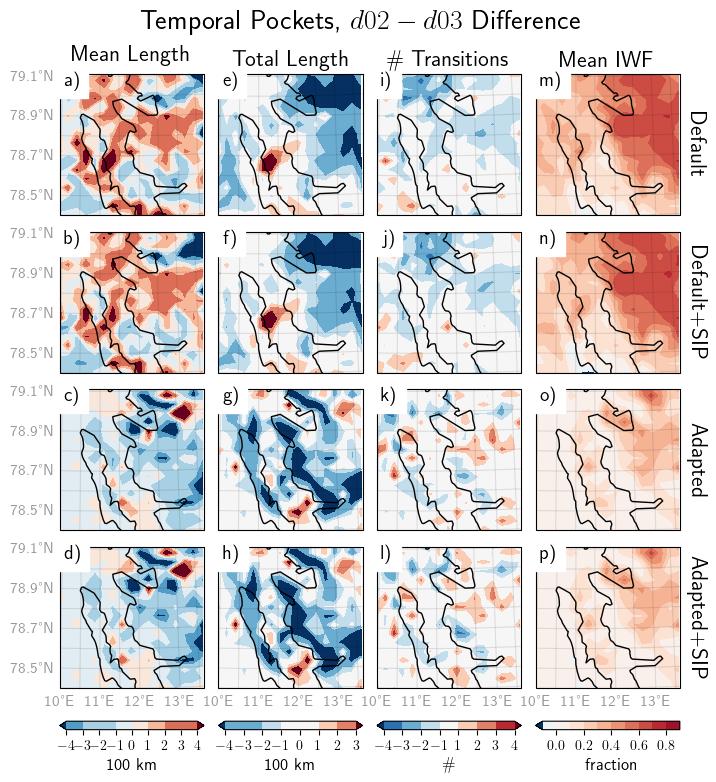

In [136]:

proj = ccrs.NorthPolarStereo(11.1)
fig, axs = plt.subplots(4, 4, figsize=(8, 8), subplot_kw={'projection': proj})

dl1 = list(np.arange(-2, -0.9, 1)) + list(np.arange(1, 6.1, 1))

diff_levels = [np.arange(-4, 4.1, 1), 
               np.arange(-4, 4, 1),
               list(np.arange(-4, -0.9, 1)) + list(np.arange(1, 4.1, 1)), 
               np.arange(-0.1, 1, 0.1)]

levels = diff_levels

norm = TwoSlopeNorm(vcenter=0)

for i, ax_col, data, iwf in zip(range(4), axs, diff, IWF_diffs):

    p1 = (data.MEAN / 100).plot.contourf(x='lon', y='lat', transform=ccrs.PlateCarree(),
            ax=ax_col[0], levels=levels[0], add_colorbar=False, extend='both', 
            norm=TwoSlopeNorm(vcenter=0, vmin=-5, vmax=5))
    
    p2 = (data.TOTAL / 100).plot.contourf(x='lon', y='lat', transform=ccrs.PlateCarree(),
            ax=ax_col[1], levels=levels[1], add_colorbar=False, extend='both', 
            norm=TwoSlopeNorm(vcenter=0, vmin=-5, vmax=5))
    
    p3 = (data.N_SEGMENTS).plot.contourf(x='lon', y='lat', transform=ccrs.PlateCarree(), cmap='RdBu_r',
            ax=ax_col[2], add_colorbar=False, extend='both', levels=levels[2], vmin=-10, vmax=10)
            #norm=TwoSlopeNorm(vcenter=0, vmin=-5, vmax=5), levels=levels[2])
    
    
    p4 = ax_col[3].contourf(data.lon, data.lat, iwf, cmap='RdBu_r', levels=levels[3],
                            interpolation='none', transform=ccrs.PlateCarree(),
                            norm=TwoSlopeNorm(vcenter=0, vmin=-1, vmax=1), extend='min')

for x in axs.flatten():
        x.set_title(None)
        x.coastlines()
        x.set_extent([10, 13.6, 78.4, 79.1], crs=ccrs.PlateCarree())

# Colorbars
cbar_ax = inset_axes(axs[3, 0], width='100%', height='6%', loc='lower center', borderpad=-3)
cb1 = plt.colorbar(p1, cbar_ax, orientation='horizontal')
cb1.set_label('100 km', fontsize=12)

cbar_ax = inset_axes(axs[3, 1], width='100%', height='6%', loc='lower center', borderpad=-3)
cb2 = plt.colorbar(p2, cbar_ax, orientation='horizontal')
cb2.set_label('100 km', fontsize=12)


cbar_ax = inset_axes(axs[3, 2], width='100%', height='6%', loc='lower center', borderpad=-3)
cb3 = plt.colorbar(p3, cbar_ax, orientation='horizontal')
cb3.set_label('\#', fontsize=12)


cbar_ax = inset_axes(axs[3, 3], width='100%', height='6%', loc='lower center', borderpad=-3)
cb4 = plt.colorbar(p4, cbar_ax, orientation='horizontal', ticks=[0, 0.2, 0.4, 0.6, 0.8])
cb4.set_label('fraction', fontsize=12)


axs[0, 0].set_title('Mean Length', size=16)
axs[0, 1].set_title('Total Length', size=16)
axs[0, 2].set_title('\# Transitions', size=16)
axs[0, 3].set_title('Mean IWF', size=16)


#fig.tight_layout()
plt.subplots_adjust(hspace=0.1, wspace=0.1)
plt.suptitle('Temporal Pockets, $d02 - d03$ Difference', y=0.96, fontsize=20)

label_style = {'size':11, 'color':'grey', 'alpha':0.8}

for i in range(4):
        for j in range(4):
                axs[i, j].gridlines(draw_labels=False, color='black', x_inline=False, y_inline=False, alpha=0.1)
        gl = axs[i, 0].gridlines(draw_labels=True, x_inline=False, y_inline=False)
        gl.xlines = gl.ylines = False
        gl.rotate_labels = False
        gl.right_labels = False
        gl.bottom_labels = False
        gl.top_labels = False
        gl.xlabel_style = gl.ylabel_style = label_style
        gl.ylocator = mticker.FixedLocator([78.5, 78.7, 78.9, 79.1, 79.3])
for i in range(4): #xgridlines and ticks
        gl = axs[3, i].gridlines(draw_labels=True, x_inline=False, y_inline=False)
        gl.xlines = gl.ylines = False
        gl.rotate_labels = False
        gl.right_labels = False
        gl.bottom_labels = True
        gl.top_labels = False
        gl.left_labels = False
        gl.xlabel_style = gl.ylabel_style = label_style
        #gl.ylocator = mticker.FixedLocator([78.5, 78.7, 78.9, 79.1, 79.3])

for i in range(4):
        axs[i, 3].text(1.05, 0.5, get_labels(i), va='bottom', ha='center',
                rotation=270, rotation_mode='anchor',
                transform=axs[i, 3].transAxes, fontsize=16)

for i, x in enumerate(axs.T.ravel()):
    x.text(x=0.03, y=0.92, s=get_subplot_label(i), transform=x.transAxes, backgroundcolor='white',
           fontsize=14)

plt.savefig('temporal_diff.png')
plt.show()

In [139]:
for i in range(4):
    print(IWF_diffs[i].mean().to_numpy())

0.3401559387567702
0.32719020458774367
0.115190193236202
0.11280691413826656


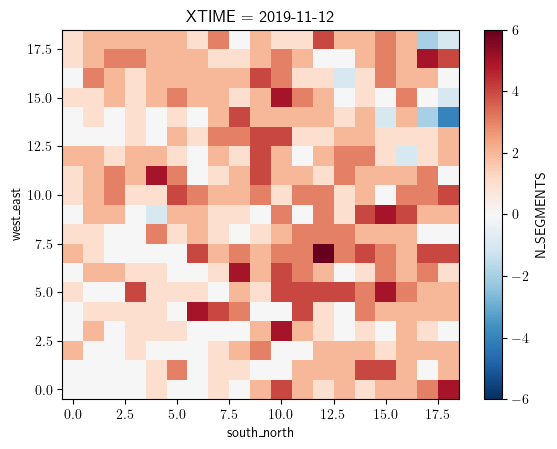

In [78]:
diff[3].N_SEGMENTS.plot()

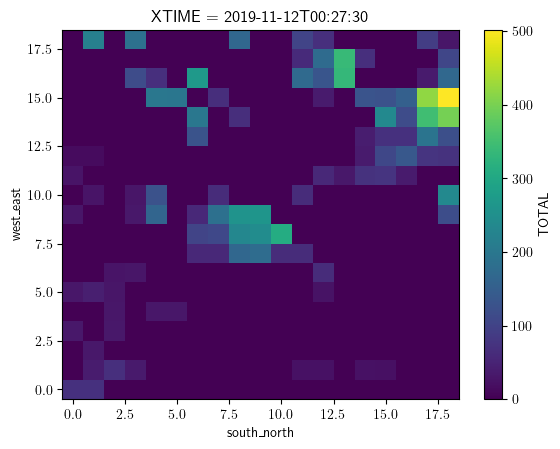

In [77]:
MAS3_DAC.TOTAL.plot()

### Segments spatial (along-wind)

##### Setup

In [4]:
################ Singular segment class
class Segment:
    def __init__(self, t, indices, lengths, transect, ds, wind_dir, updrafts):
        self.t = t
        self.lengths = lengths
        self.indices = indices
        self.transect = transect
        self.ds = ds
        self.n_points = len(self.transect[0])
        self.n_pockets = len(self.lengths)
        self.wind_dir = wind_dir
        self.updrafts = updrafts
        self.mean = self.lengths.mean()
        self.std = self.lengths.std()
      
    def plot_lengths(self, ax=None):
        if ax is None:
            plt.plot(np.arange(self.n_pockets), self.lengths)
            plt.xlabel('Pocket number')
            plt.ylabel('Pocket length [km]')
        ax.plot(np.arange(self.n_pockets), self.lengths, label=self.t)

    def plot_transect(self, ax=None):
        if ax is None:
            fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.NorthPolarStereo(11.1)})
            ax.set_extent([min(self.transect[0]), max(self.transect[0]),
                           min(self.transect[1]), max(self.transect[1])])
            ax.gridlines()
            ax.coastlines()
        ax.plot(self.transect[0], self.transect[1], label=self.t, transform=ccrs.PlateCarree(), color='red')

############## Collective class (each timestep)

class Segments:
    def __init__(self, data, t, H, wind_dir):
        self.t = t
        self.H = H
        self.wind_dir = wind_dir

        self.all_segments = []
        self.data = data

    def new_seg(self, seg):
        self.all_segments.append(seg)

    def visualize(self, ax=None):
        if ax is None:
            fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.NorthPolarStereo(11.1)})
            ax.set_extent([self.data.XLONG.isel(Time=1).min(), self.data.XLONG.isel(Time=1).max(),
                                self.data.XLAT.isel(Time=1).min(), self.data.XLAT.isel(Time=1).max()])
            ax.coastlines()
            ax.gridlines()
        [e.plot_transect(ax=ax) for e in self.all_segments]
  
    def all_pockets(self):
        all = []
        for S in self.all_segments:
            all += list(S.lengths)
        return np.array(all)

    def all_updrafts(self):
        all = []
        for S in self.all_segments:
            try:
                all += flatten_list(list(S.updrafts))
            except TypeError:
                all += []
        return np.array(all)
  
    @property
    def mean_updraft(self):
        return self.all_updrafts().mean()
  
    @property
    def mean(self):
        return self.all_pockets().mean()

    @property
    def total_length(self):
        L = 0
        for e in self.all_segments:
            loc1 = (e.transect[1][0], e.transect[0][0])
            loc2 = (e.transect[1][-1], e.transect[0][-1])
            L += hs.haversine(loc1, loc2)
        return L

    @property
    def n_pockets(self):
        return len(self.all_pockets())
    
######################### Helper functions

def get_ds(interline):
    n_points = len(interline)
    ds = np.zeros(n_points - 1)

    for i in range(n_points - 1):
        loc1 = (float(str(interline[i].coords['xy_loc'].to_numpy()).split('=')[-2][:-5]),
                float(str(interline[i].coords['xy_loc'].to_numpy()).split('=')[-1][:-2]))
        loc2 = (float(str(interline[i + 1].coords['xy_loc'].to_numpy()).split('=')[-2][:-5]), 
                float(str(interline[i + 1].coords['xy_loc'].to_numpy()).split('=')[-1][:-2]))
        ds[i] = hs.haversine(loc1, loc2)
    return ds.mean()

def get_coords(interline):
    n_points = len(interline)
    lats = []
    lons = []
    for i in range(n_points):
        loc1 = (float(str(interline[i].coords['xy_loc'].to_numpy()).split('=')[-1][:-2]), 
                float(str(interline[i].coords['xy_loc'].to_numpy()).split('=')[-2][:-5]))
        lats.append(loc1[1])
        lons.append(loc1[0])
    return [lons, lats]




############################ Main function
def segment_lengths_alongwind(data, datapath, condition='== 0.5', IWF_masked=None, CTL=None, 
            from_time=0, to_time=None, mass=True, cld_thrsh=0.5, n_levels=7, phase_thrsh=0.1,
            transect_step=5, alongwind=True):
    if from_time is None:
        from_time = 0
    t = timer()
    t.start()
    if CTL is None:
        print('Getting Cloud-Top...')
        CTL = find_top(data, datapath, cld_thrsh=cld_thrsh, t=slice(from_time, to_time))
        print(f'Done. {t.round()}')
        
    if IWF_masked is None:
        print('Calculating IWF...')
        IWF = select_top(iwf_calc(data, mass=mass, cld_thrsh=cld_thrsh, t=slice(from_time, to_time)), 
                 CTL.isel(Time=slice(from_time, to_time)), 
                 n_levels=n_levels).mean(dim='bottom_top')
        IWF_masked = xr.where(IWF > 1 - phase_thrsh, x = 1, y = IWF)
        IWF_masked = xr.where(IWF_masked <= phase_thrsh, x = 0, y = IWF_masked)
        IWF_masked = xr.where((IWF_masked > phase_thrsh) & (IWF_masked < 1 - phase_thrsh), x = 0.5, y = IWF_masked)
        print(f'Done. {t.round()}')


    def ff(t):
        H = int(CTL.isel(Time=t).mean())
        ncdata = nc.Dataset(datapath)

        wind_dir = int(wrf.getvar(ncdata, 'wdir', timeidx=t).isel(bottom_top=H).mean())
        addx, addy = 0, 99
        if not alongwind:
            addx, addy = 0, 0
            wind_dir -= 90
            if wind_dir < 0:
                wind_dir = 360 + wind_dir

        info = [t, H, wind_dir]
        transects = []
        for i in range(15, 86, transect_step):
            lat, lon = wrf.xy_to_ll(ncdata, x = abs(addx - i), y = abs(addy - i))
            pivot_point = wrf.CoordPair(lat=lat, lon=lon)
            
            interline = wrf.interpline(IWF_masked.isel(Time=t), wrfin=nc.Dataset(datapath), 
                        pivot_point=pivot_point, angle=wind_dir, latlon=True, meta=True)

            ds = get_ds(interline)
            
            phase_interline = np.where(eval('interline.to_numpy()' + condition))[0]
            indices = consecutive(phase_interline)
            trans_coords = get_coords(interline)

            #Finding pocket updraft
            inds = flatten_list(indices)
            lons, lats = np.array(trans_coords)[:, inds]
            x, y = wrf.ll_to_xy(ncdata, longitude=lons, latitude=lats).to_numpy()
            level = CTL.isel(Time=t, west_east=x, south_north=y)

            try:
                pocket_w = data.W.isel(Time=t, bottom_top_stag=level, west_east=x, south_north=y).to_numpy()
            except ValueError:
                pocket_w = np.array([])

            
            lengths = np.array([len(ind) * ds for ind in indices])
            transects.append([t, indices, lengths, trans_coords, ds, wind_dir, pocket_w])
        return [info, transects]

    upto = to_time
    if to_time is None:
        upto = len(data.Time)
    #set_loky_pickler('pickle')
    #with tqdm_joblib('Progress', total=upto - from_time) as progress_bar:
    #    results = Parallel(n_jobs=-2)(delayed(ff)(t) for t in range(from_time, upto))
    
    results = []
    for t in tqdm.tqdm(range(from_time, upto)):
        results.append(ff(t))
    
    to_ret = []
    for timestep in results:
        t, H, wind_dir = timestep[0]
        Seg = Segments(data=data, t=t, H=H, wind_dir=wind_dir)
        for transect in timestep[1]:
            t, indices, lengths, trans, ds, wind_dir, w = transect
            
            #def find_updraft(i):
            #   lon, lat = np.array(trans)[:, i]
            #   x, y = wrf.ll_to_xy(nc.Dataset(datapath), latitude=lat, longitude=lon)
            #   return float(data.W.isel(Time=t, west_east=x, south_north=y,
            #                bottom_top_stag=CTL.isel(Time=t, west_east=x, south_north=y)))

            #updrafts = Parallel(n_jobs=-2)(delayed(find_updraft)(i) for i in functools.reduce(operator.iconcat, indices, []))


            #Seg.new_seg(Segment(*transect, updrafts=updrafts))
            Seg.new_seg(Segment(t=t, indices=indices, lengths=lengths, transect=trans, 
                                ds=ds, wind_dir=wind_dir, updrafts=w))
        to_ret.append(Seg)

    return to_ret

In [30]:
#MD3_mass_along = segment_lengths_alongwind(MD3, MorrisonDefault3, condition='< 0.5', 
#                                            from_time=0, to_time=220, mass=True, cld_thrsh=0.5, 
#                                            n_levels=7, phase_thrsh=0.1, transect_step=5, alongwind=True)
#MDS3_mass_along = segment_lengths_alongwind(MDS3, MorrisonDefaultSIP3, condition='< 0.5', 
#                                            from_time=0, to_time=220, mass=True, cld_thrsh=0.5, 
#                                            n_levels=7, phase_thrsh=0.1, transect_step=5, alongwind=True)
#MA3_mass_along = segment_lengths_alongwind(MA3, MorrisonAdapted3, condition='< 0.5', 
#                                            from_time=0, to_time=220, mass=True, cld_thrsh=0.5, 
#                                            n_levels=7, phase_thrsh=0.1, transect_step=5, alongwind=True)
MAS3_mass_along = segment_lengths_alongwind(MD3, MorrisonDefault3, condition='< 0.5', 
                                            from_time=0, to_time=20, mass=True, cld_thrsh=0.5, 
                                            n_levels=7, phase_thrsh=0.1, transect_step=5, alongwind=True)

Getting Cloud-Top...
Done. Elapsed time: 0.4535 seconds
Calculating IWF...
Done. Elapsed time: 0.6182 seconds


100%|██████████| 20/20 [02:14<00:00,  6.72s/it]


In [92]:
MD3_mass_along = load('analysis_data/spatial_segments/ice/MD3_mass_along.pkl')
MDS3_mass_along = load('analysis_data/spatial_segments/ice/MDS3_mass_along.pkl')
MA3_mass_along = load('analysis_data/spatial_segments/ice/MA3_mass_along.pkl')
MAS3_mass_along = load('analysis_data/spatial_segments/ice/MAS3_mass_along.pkl')

##### Results

In [3]:
MD3_mass_along = load('analysis_data/spatial_segments/mixed/MD3_mass_along.pkl')
MDS3_mass_along = load('analysis_data/spatial_segments/mixed/MDS3_mass_along.pkl')
MA3_mass_along = load('analysis_data/spatial_segments/mixed/MA3_mass_along.pkl')
MAS3_mass_along = load('analysis_data/spatial_segments/mixed/MAS3_mass_along.pkl')

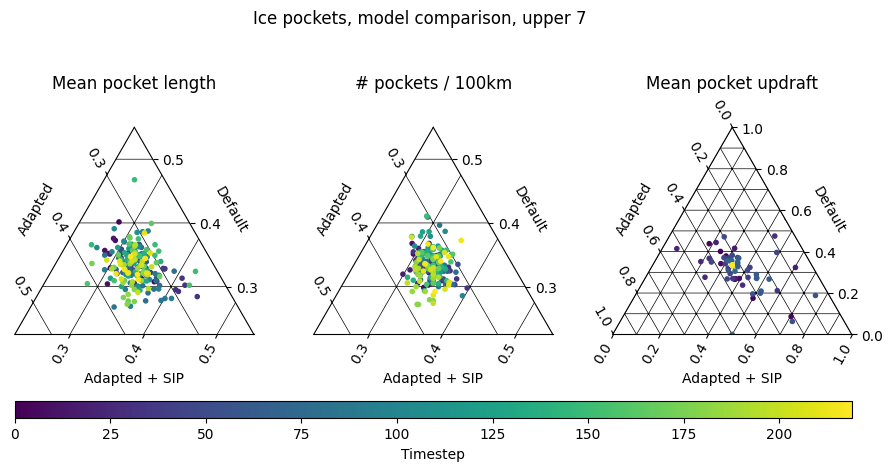

In [28]:
def ternary_plot():
    # Transformin data to 3xn array
    MorMeans = np.array([e.mean for e in MD3_mass_along])
    MorNpock = np.array([e.n_pockets for e in MD3_mass_along])
    MorUpdraft = np.array([e.mean_updraft for e in MD3_mass_along])

    for a in [MA3_mass_along, MAS3_mass_along]:
        MorMeans = np.concatenate([MorMeans, np.array([e.mean for e in a])])
        MorNpock = np.concatenate([MorNpock, np.array([e.n_pockets for e in a]) / 
                                            np.array([e.total_length for e in a]) * 100])
        MorUpdraft = np.concatenate([MorUpdraft, np.array([e.mean_updraft for e in a]) / 
                                            np.array([e.mean_updraft for e in a]) * 100])
        
    MorMeans = np.reshape(MorMeans, newshape=(220, 3))
    MorNpock = np.reshape(MorNpock, newshape=(220, 3))
    MorUpdraft = np.reshape(MorUpdraft, newshape=(220, 3))

    # Plotting in triangle
    t, l, r = get_triangular_grid()
    fig, ax = plt.subplots(1, 3, figsize=(10.8, 4.8), subplot_kw={'projection': 'ternary'})

    
    #ax1 = fig.add_subplot(121, projection='ternary')
    for i, x in enumerate(ax):
        x.triplot(t, l, r, color='k', linewidth=0.5)
        x.set_tlabel('Default')
        x.set_llabel('Adapted')
        x.set_rlabel('Adapted + SIP')
        if i != 2:
            x.set_ternary_min(0.25, 0.25, 0.25)
            x.set_ternary_max(0.55, 0.55, 0.55)
        x.taxis.set_label_position('tick1')
        x.laxis.set_label_position('tick1')
        x.raxis.set_label_position('tick1')

    p = ax[0].scatter(*zip(*MorMeans), c=np.arange(220), marker='.')
    ax[1].scatter(*zip(*MorNpock), c=np.arange(220), marker='.')
    ax[2].scatter(*zip(*MorUpdraft), c=np.arange(220), marker='.')
    plt.subplots_adjust(wspace=0.25)

    ax[0].set_title('Mean pocket length', y=1.15)
    ax[1].set_title('# pockets / 100km', y=1.15)
    ax[2].set_title('Mean pocket updraft', y=1.15)

    #cax = plt.axes([0.85, 0.1, 0.075, 0.8])

    fig.colorbar(p, ax=ax.ravel().tolist(), orientation='horizontal', label='Timestep', 
                fraction=0.07, aspect=50, pad=0.18)
    fig.suptitle('Ice pockets, model comparison, upper 7')

    plt.show()
ternary_plot()

In [22]:
def plot_segment_timeseries(res, ax=None, iwf_type='Mass', angle='Along', H=None, legend=True, title=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    t0, t1 = res[0].t, res[-1].t + 1
    x = MD3.XTIME.isel(Time=slice(0, 220))

    ax.set_ylabel('km | #/100km')
    ax.set_ylim([0, 30])
    ax.grid()
    ax.set_xlim(x[0], x[-1])
    axW = ax.twinx()
    axW.set_ylim(-0.055, 0.055)
    #axW.hlines(0, x[0], x[-1], linestyles='dashed', color='red')
    
    ax.plot(x, np.array([e.mean for e in res]), color='k', linewidth=3, label='Mean pocket length')
    ax.plot(x, np.array([e.n_pockets for e in res]) / 
            np.array([e.total_length for e in res]) * 100, linewidth=3, label='# pockets / 100km')
    

    conf = np.array([sms.DescrStatsW(e.all_pockets()).tconfint_mean() for e in res])
    ax.fill_between(x, conf[:, 0], conf[:, 1], alpha=0.3, color='k', label='95% confidence')

    
    if legend:
        ax.legend(loc='upper left', fontsize=10)
    #ax.set_title('Along-wind cloud-top mixed-phase pocket statistics, d03/{iwf_type}')
    ax.set_title(f'{iwf_type} concentration')
    if title is not None:
        ax.set_title(title)
    

    w = [e.mean_updraft for e in res]

  
    axW.plot(x, w, label='Pocket updraft', color='red', linestyle='solid')
    axW.set_ylabel('m/s')

    p = None
    if H is not None:
        p = axW.scatter(x, np.zeros(len(x)) + -0.055, c=[e.H for e in res], s=80, 
                    cmap='bwr', label='CT height', vmin=39, vmax=55)
    if legend:
        axW.legend(loc='upper right', fontsize=10)    
    return p 


Text(0.5, 0.98, 'Ice pockets, mass, upper 7')

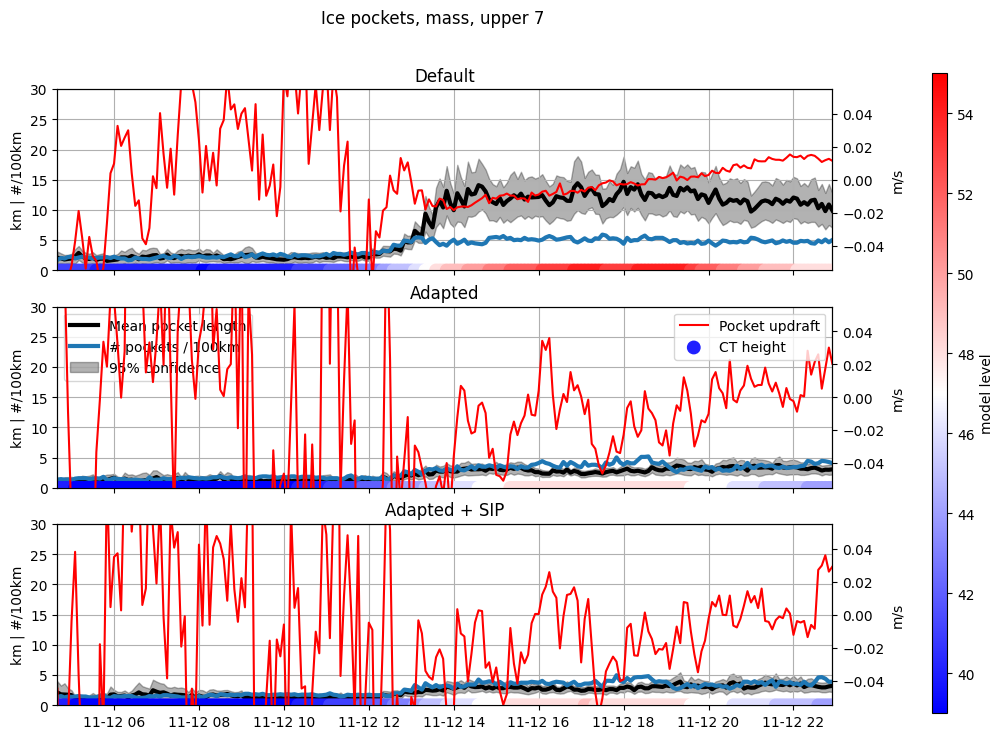

In [25]:
fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharex=True, sharey=True)
plot_segment_timeseries(MD3_mass_along, ax=ax[0], H=True, title='Default', legend=False)
plot_segment_timeseries(MA3_mass_along, ax=ax[1], H=True, title='Adapted')
p = plot_segment_timeseries(MAS3_mass_along, ax=ax[2], H=True, legend=False, title='Adapted + SIP')

cax = fig.add_axes([1, 0.1, 0.015, 0.8])

fig.colorbar(p, cax=cax, label='model level')
fig.suptitle('Ice pockets, mass, upper 7')

In [4]:
MD3 = xr.open_dataset('/nird/projects/NS9600K/brittsc/211108_WRF_NYA/wrfout_d03_2019-11-11_12:00:00', 
                      engine='netcdf4').isel(Time=slice(144, -1), bottom_top=slice(0, 85))

In [5]:
datas = [xr.open_dataset(datapath).isel(Time=slice(144, None), 
                                        bottom_top=slice(0, 85)) for datapath in d3]
print('Data acquired')
Ts = [wrf.tk(data['P'] + data['PB'], data['T'] + 300) for data in datas]

Data acquired


In [6]:
cloudtops = [find_top(data, datapath) for data, datapath in zip(datas, d3)]

In [7]:
Ttops = [select_top(T, CT, n_levels=7).mean(dim=['bottom_top', 
                                                 'south_north', 
                                                 'west_east']) for T, CT in zip(Ts, cloudtops)]

In [8]:
H = wrf.getvar(nc.Dataset(d3[0]), 'z')[:85, 10,10]

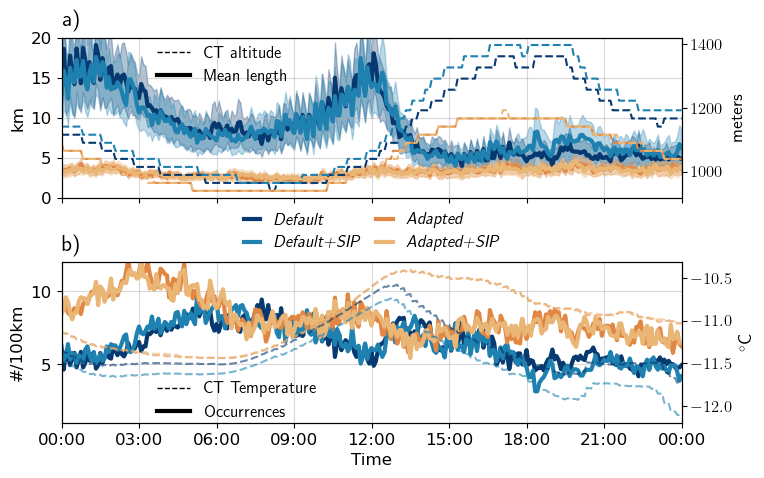

In [13]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 500
def compare_segments():
    plt.style.use('default')

    fig, ax = plt.subplots(2, 1, figsize=(8, 5), sharex=True)

    t0, t1 = MD3_mass_along[0].t, MD3_mass_along[-1].t + 1
    x = xr.open_dataset('/nird/projects/NS9600K/brittsc/211108_WRF_NYA/wrfout_d03_2019-11-11_12:00:00', 
                      engine='netcdf4').isel(Time=slice(144, None), bottom_top=slice(0, 85)).XTIME

    data = [MD3_mass_along, MDS3_mass_along, MA3_mass_along, MAS3_mass_along]
    #Ts = [TD, TA, TAS]
    plt.rc('text', usetex=True)
    labels = [r'\textit{Default}', r'\textit{Default+SIP}', r'\textit{Adapted}', r'\textit{Adapted+SIP}']
    colors = ['#063970', '#1e81b0', '#e28743', '#eab676']
    #ff7f00
    #ffff33
    #a65628
    #f781bf]

    axH = ax[0].twinx()
    axH.set_ylabel('meters', size=13)
    #axH.set_ylim(38, 56)

    axT = ax[1].twinx()
    axT.set_ylabel('$^\circ$C', size=13)

    for res, T, lab, c in zip(data, Ttops, labels, colors):
        ax[0].plot(x, np.array([e.mean for e in res]), color=c, linewidth=3, label=lab)


        axH.plot(x, [H[e.H] for e in res], color=c, linestyle='dashed', alpha=1)
        
        ax[1].plot(x, np.array([e.n_pockets for e in res]) / 
                np.array([e.total_length for e in res]) * 100, linewidth=3, color=c)
        conf = np.array([sms.DescrStatsW(e.all_pockets()).tconfint_mean() for e in res])
        axT.plot(x, T - 273.15, linestyle='dashed', color=c, alpha=0.6)

        ax[0].fill_between(x, conf[:, 0], conf[:, 1], alpha=0.3, color=c)#, label='95% confidence')


    ax[0].legend(loc='upper center', frameon=False, ncols=2, fontsize=12, handlelength=1, columnspacing=1,
                 bbox_to_anchor=(0.5, -0.00))
    
    ax[0].set_ylim(0, 20)
    ax[0].set_xlim(x[0], x[-1])

    handles = [Line2D([0], [0], color='k', lw=1, label='CT altitude', linestyle='dashed'), 
               Line2D([0], [0], color='k', lw=3, label='Mean length')]

    axH.legend(handles=handles, loc='upper left', bbox_to_anchor=(0.13, 1.04), fontsize=12, frameon=False)


    handles = [Line2D([0], [0], color='k', lw=1, label='CT Temperature', linestyle='dashed'), 
               Line2D([0], [0], color='k', lw=3, label='Occurrences')]
    #handles = [Line2D([0], [0], color='k', lw=3, label='Pocket frequency')]
    axT.legend(handles=handles, frameon=False, fontsize=12, loc='lower left', bbox_to_anchor=(0.13, -0.08))
    ax[0].set_ylabel('km', size=12)
    ax[1].set_ylabel('#/100km', size=12)
    ax[1].set_xlabel('Time', size=12)
    ax[1].set_ylim(1, 12)
    [ax.grid(alpha=0.5) for ax in ax]

    ax[1].set_xticks(list(MD3.XTIME[::36].to_numpy()) + [datetime(2019, 11, 13, 0, 0)])
    ax[1].set_xticklabels([str(i*3) + ':00' if i*3 > 9 else '0' + str(i*3) + ':00' for i in range(8)] + ['00:00'])

    #ax[0].set_title('Glaciated Cloud-Top', y=1.08, size=20, loc='left')
    [x.tick_params(labelsize=12) for x in [axH, axT]]

    labels = ['a)', 'b)', 'c)']
    for i,x in enumerate(ax):
        x.tick_params(labelsize=12)

        x.text(x=0, y=1.07, s=labels[i], transform=x.transAxes,
            fontsize=16)


    plt.subplots_adjust(hspace=0.4)

    plt.show()
compare_segments()

In [12]:
means = [0, 0, 0, 0



SyntaxError: invalid syntax (2998021734.py, line 2)

In [17]:
H[26:66] - H[25:65]

<xarray.DataArray 'height' (bottom_top: 40)>
array([24.112549, 24.169373, 24.22705 , 24.284607, 24.343689, 24.404602,
       24.465027, 24.526001, 24.588257, 24.649963, 24.712524, 24.776001,
       24.838318, 24.896912, 24.95282 , 25.01062 , 25.071167, 25.134705,
       25.200806, 25.269287, 25.340698, 25.423096, 25.52002 , 25.625366,
       30.044067, 34.507446, 34.707397, 34.913574, 35.11902 , 35.30945 ,
       35.48694 , 35.661865, 35.83484 , 36.00598 , 36.17334 , 36.33911 ,
       36.506348, 36.673706, 36.84021 , 37.00586 ], dtype=float32)
Coordinates:
    XLONG    float32 9.884
    XLAT     float32 78.47
    XTIME    float32 0.0
    Time     datetime64[ns] 2019-11-11T12:00:00
Dimensions without coordinates: bottom_top

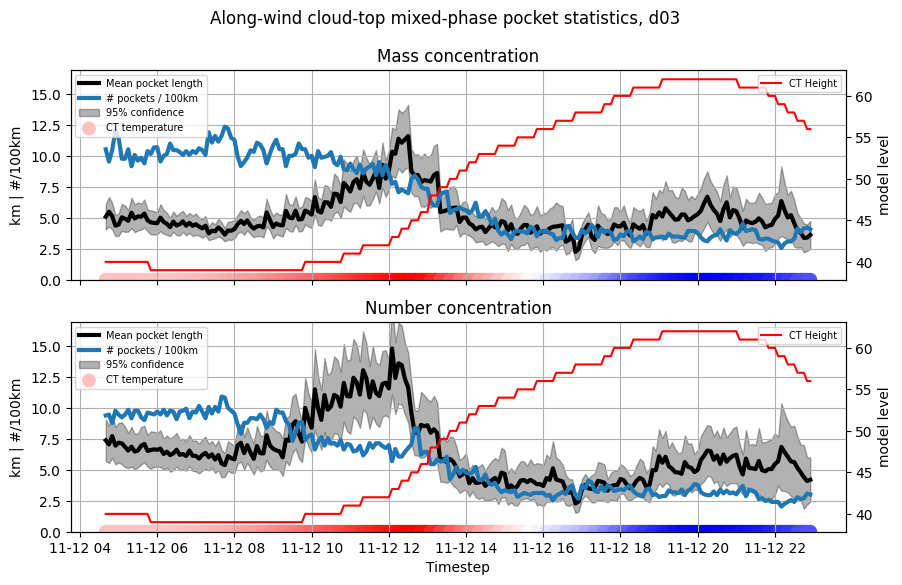

In [98]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True, sharey=True)
fig.suptitle('Along-wind cloud-top mixed-phase pocket statistics, d03')
ax[1].set_xlabel('Timestep')
plot_segment_timeseries(mass_along, ax=ax[0], iwf_type='Mass')
plot_segment_timeseries(number_along, ax=ax[1], iwf_type='Number')
plt.show()

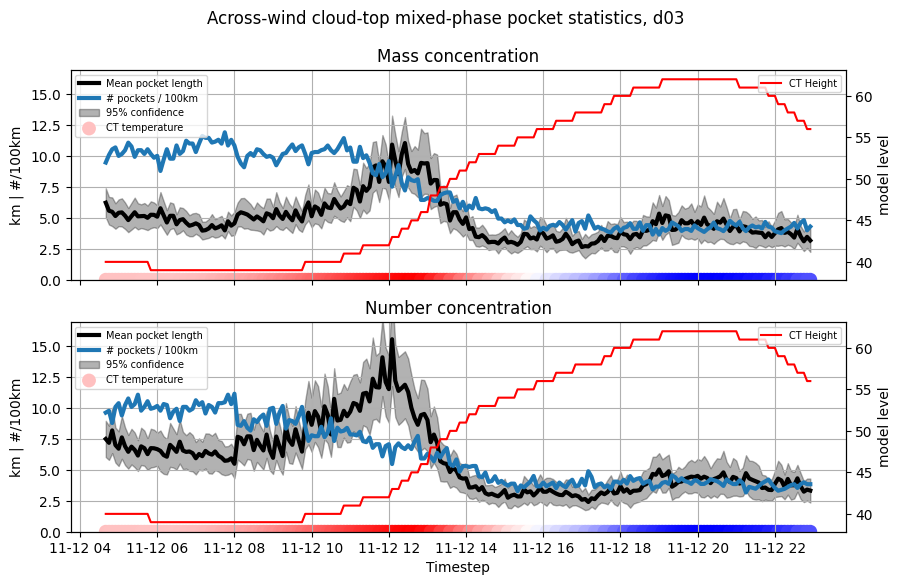

In [99]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True, sharey=True)
fig.suptitle('Across-wind cloud-top mixed-phase pocket statistics, d03')
ax[1].set_xlabel('Timestep')
plot_segment_timeseries(mass_across, ax=ax[0], iwf_type='Mass')
plot_segment_timeseries(number_across, ax=ax[1], iwf_type='Number')
plt.show()

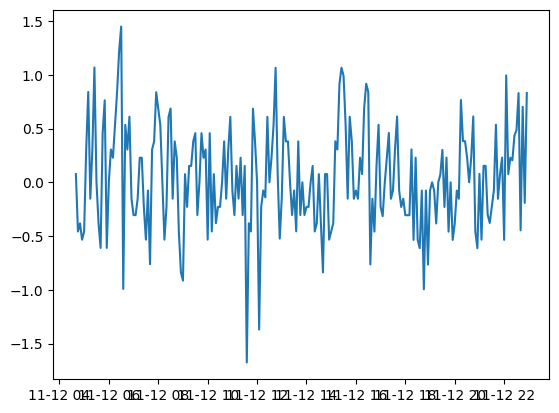

In [121]:
y1 = np.array([e.n_pockets for e in MA3_mass_along]) / np.array([e.total_length for e in MA3_mass_along]) * 100
y2 = np.array([e.n_pockets for e in MAS3_mass_along]) / np.array([e.total_length for e in MAS3_mass_along]) * 100
x = Mil3.XTIME.isel(Time=slice(0, 220))
plt.plot(x, y2 - y1)

In [122]:
y1 - y2

array([-0.07630934,  0.45785605,  0.38154671,  0.53416539,  0.45860248,
       -0.30573499, -0.84077122,  0.15286749, -0.30573499, -1.06833079,
        0.        ,  0.38098588,  0.61047473, -0.45785605, -0.76309342,
        0.61047473,  0.        , -0.30523737, -0.22892803, -0.53416539,
       -0.83940276, -1.22094947, -1.4498775 ,  0.99202144, -0.53416539,
       -0.30523737, -0.61047473,  0.15261868,  0.30523737,  0.30523737,
        0.15239435, -0.22859153, -0.22859153,  0.22859153,  0.53338024,
        0.07619718,  0.76197177, -0.30478871, -0.38098588, -0.83816894,
       -0.68577459, -0.53338024,  0.        ,  0.53338024,  0.22859153,
       -0.60957741, -0.68577459,  0.15239435, -0.38098588, -0.22859153,
        0.45718306,  0.83816894,  0.91436612, -0.07619718,  0.22859153,
       -0.15239435, -0.15239435, -0.38098588, -0.45718306,  0.30478871,
        0.        , -0.45718306, -0.22859153, -0.30478871,  0.53338024,
       -0.45718306,  0.45718306, -0.07619718,  0.38098588,  0.22

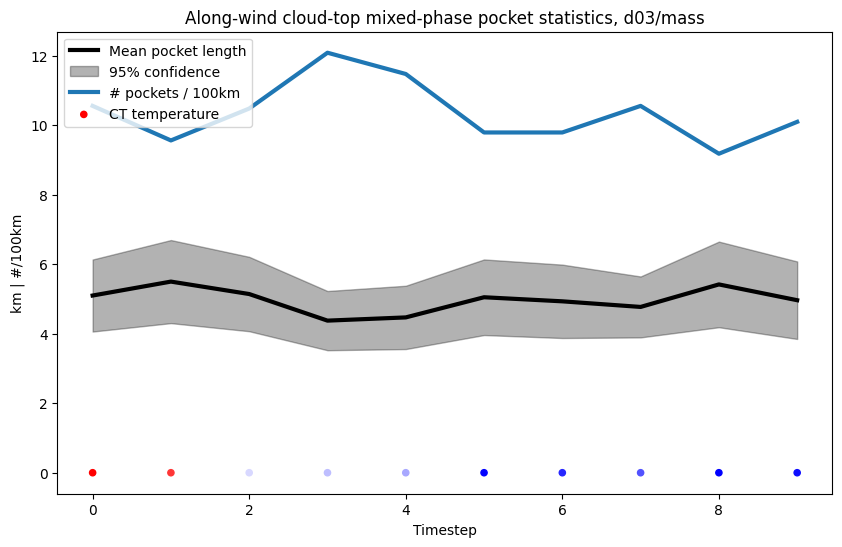

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
t0, t1 = res[0].t, res[-1].t + 1

x = np.arange(len(res))
y = np.array([e.mean for e in res])
ax.plot(x, y, color='k', linewidth=3, label='Mean pocket length')

conf = np.array([sms.DescrStatsW(e.all_pockets()).tconfint_mean() for e in res])



ax.fill_between(x, conf[:, 0], conf[:, 1], alpha=0.3, color='k', label='95% confidence')
#ax.plot(x, minl, linestyle='dashed', color='k')
#ax.plot(x, maxl, linestyle='dashed', color='k')

ax.plot(x, np.array([e.n_pockets for e in res]) / 
           np.array([e.total_length for e in res]) * 100, linewidth=3, label='# pockets / 100km')

T = select_top(calc_T(Mil3, slice(t0, t1)), CTL.isel(Time=slice(t0, t1)), n_levels=7).mean(
    dim=['bottom_top', 'west_east', 'south_north'])
ax.scatter(x, np.zeros(len(x)), c=T, s=20, cmap='bwr', label='CT temperature')

ax.legend(loc='upper left')
ax.set_title('Along-wind cloud-top mixed-phase pocket statistics, d03/mass')
ax.set_xlabel('Timestep')
ax.set_ylabel('km | #/100km')
plt.show()

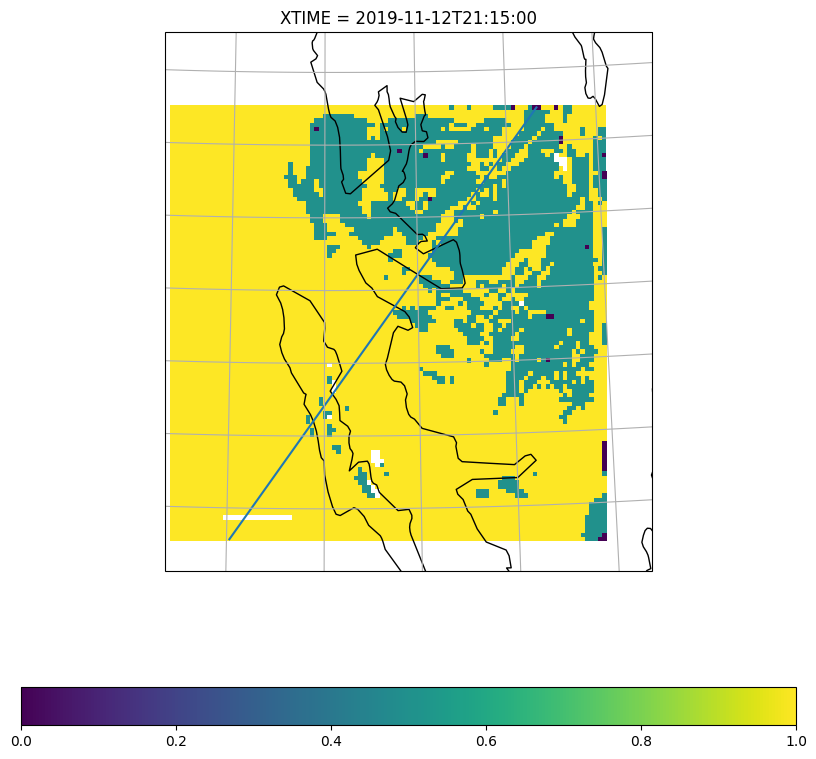

In [273]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': ccrs.NorthPolarStereo(11.1)})

IWF_masked.isel(Time=199).plot(x='XLONG', y='XLAT', ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal'})

#ax.plot(lons, lats, transform=ccrs.PlateCarree(), color='red')
res[199].plot_transect(ax=ax)
ax.coastlines()
ax.set_extent([NYA.lon - 2.55, NYA.lon + 2.4, NYA.lat - 0.6, NYA.lat + 0.5], crs=ccrs.PlateCarree())
ax.gridlines()

# Comparison with HoloBalloon

In [216]:
def datenum_to_datetime(datenum):
    """
    Convert Matlab datenum into Python datetime.
    :param datenum: Date in datenum format
    :return:        Datetime object corresponding to datenum.
    """
    if len(datenum.shape) == 0:
        days = datenum % 1
        return dt.datetime.fromordinal(int(datenum)) \
            + dt.timedelta(days=days) \
            - dt.timedelta(days=366)
    else:
        dates = []
        for dn in datenum:
            days = dn % 1
            dates.append(dt.datetime.fromordinal(int(dn)) \
                         + dt.timedelta(days=days) \
                         - dt.timedelta(days=366))
        return np.array(dates)

def holoInCloudMsk(inp, data):
    msk = xr.where(data.instData_incloud == 1, x=1, y=np.nan)
    return inp * msk

def _convert(datapath=None, loc=(78.92759354100885, 11.94456029591745)):
    '''Prepares model dataset for a 2x2 box around specified location only.
    Upto model level 85, time from 10:00 to 18:00'''
    HB_x, HB_y = wrf.ll_to_xy(wrfin=nc.Dataset(datapath), 
                          latitude=loc[0], longitude=loc[1], meta=False)
    
    xslice = slice(HB_x, HB_x + 2)
    yslice = slice(HB_y, HB_y + 2)

    data = xr.open_dataset(datapath, engine='netcdf4').isel(bottom_top=slice(0, 85),
                                                            Time=slice(264, -71), 
                                                            bottom_top_stag=slice(0, 85), 
                                                            west_east=xslice, 
                                                            south_north=yslice)

    P = data['P'] + data['PB']
    theta = data['T'] + 300 #+ data['T00'] NO clue why
    T = wrf.tk(P, theta)
    Tv = wrf.tvirtual(T, data['QVAPOR'], units='K')
    density = P / (287 * Tv)

    convert_vars_gm3 = ['QVAPOR', 'QCLOUD', 'QRAIN', 'QICE', 'QSNOW', 'QGRAUP']
    for var in tqdm.tqdm(convert_vars_gm3, desc='Converting units'):
        with xr.set_options(keep_attrs=True):
            data[var] = convert_to_gm3(data[var], density)
            data[var].attrs['units'] = 'g m-3'

    convert_vars_m3 = ['QNICE', 'QNSNOW', 'QNGRAUPEL']
    for var in tqdm.tqdm(convert_vars_m3, desc='Converting units'):
        with xr.set_options(keep_attrs=True):
            data[var] = convert_to_m3(data[var], density)
            data[var].attrs['units'] = 'm-3'
    return data

In [294]:
get_datapaths()

['/nird/projects/NS9600K/brittsc/211108_WRF_NYA/wrfout_d03_2019-11-11_12:00:00',
 '/nird/projects/NS9600K/brittsc/230123_Morrison_def_SIP_mod_HM_limits/wrfout_d03_2019-11-11_12:00:00',
 '/nird/projects/NS9600K/brittsc/221126_Morrison_adapted_no_SIP/wrfout_d03_2019-11-11_12:00:00',
 '/nird/projects/NS9600K/brittsc/230213_Morrison_moved_NISG_SIP/wrfout_d03_2019-11-11_12:00:00']

In [217]:
datas = [_convert(get_datapaths(i)) for i in range(4)]# in datapaths]

Converting units: 100%|██████████| 3/3 [00:21<00:00,  7.28s/it]


In [191]:
CLD = [xr.where(data.CLDFRA.mean(dim=[
    'west_east', 
    'south_north']) > 0.99, x=1, y=np.nan) for data in datas]

In [192]:
TWCs = [(all_ice(data, mass=True).mean(dim=[
    'west_east', 
    'south_north']) + all_liquid(data, mass=True).mean(dim=[
        'west_east', 
        'south_north'])) * cld for data, cld in zip(datas, CLD)]

In [193]:
IWCs = [all_ice(data, mass=True).mean(dim=[
    'west_east', 
    'south_north']) * cld for data, cld in zip(datas, CLD)]

In [218]:
ICNCs = [all_ice(data, mass=False).mean(dim=[
    'west_east', 
    'south_north']) * cld for data, cld in zip(datas, CLD)]

In [194]:
IWFs = [iwc / twc for iwc, twc in zip(IWCs, TWCs)]

In [347]:
# Finding position of HoloBalloon in model coordinates
#HB_pos = (78.92759354100885, 11.94456029591745)
#HB_x, HB_y = wrf.ll_to_xy(wrfin=nc.Dataset(MorrisonDefault3), 
#                          latitude=HB_pos[0], longitude=HB_pos[1], meta=False)

# Selecting a box around the HoloBalloon of 4 grid points in the model
MH = xr.open_dataset(get_datapaths(0)).isel(west_east=slice(HB_x, HB_x + 2), 
                                            south_north=slice(HB_y, HB_y + 2), 
                                            Time=slice(264, -71), 
                                            bottom_top=slice(0, 85))

#IWF = iwf_calc(MH)
#base = find_base(MH, MorrisonDefault3, cld_thrsh=0.5, 
#                 xslice=slice(HB_x, HB_x + 2), 
#                 yslice=slice(HB_y, HB_y + 2))
#top = find_top(MH, MorrisonDefault3, cld_thrsh=0.5, 
#               xslice=slice(HB_x, HB_x + 2), yslice=slice(HB_y, HB_y + 2))

In [345]:
HB_pos=(78.92759354100885, 11.94456029591745)

In [343]:
MD3 = xr.open_dataset(get_datapaths(0))

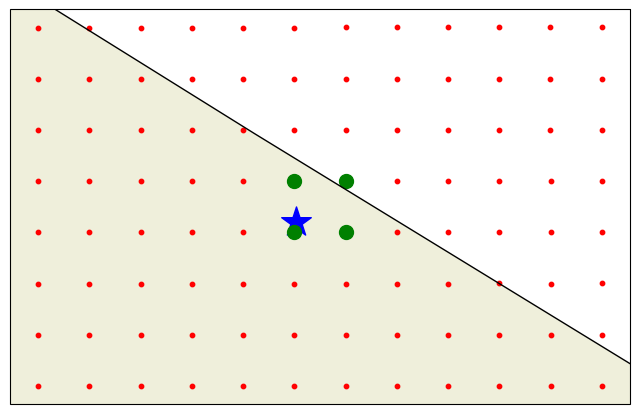

In [359]:
import cartopy.feature as cfeature
dat = MD3.isel(west_east=slice(50, 62), south_north=slice(57, 65))
fig, ax = plt.subplots(1, 1, figsize=(8, 6), subplot_kw={'projection': ccrs.NorthPolarStereo(11.1)})
#dat.T2.isel(Time=0).plot(x='XLONG', y='XLAT', ax=ax, alpha=0.5, add_colorbar=False, transform=ccrs.PlateCarree())
ax.scatter(dat.XLONG.isel(Time=0), dat.XLAT.isel(Time=0), c='r', s=10, transform=ccrs.PlateCarree())
ax.scatter(HB_pos[1], HB_pos[0], marker='*', c='b', s=500, transform=ccrs.PlateCarree())
ax.scatter(MH.XLONG.isel(Time=0), MH.XLAT.isel(Time=0), c='g', s=100, transform=ccrs.PlateCarree())
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.LAKES)
#ax.background_img(name='NaturalEarthRelief', resolution='high')
#ax.add_feature(cfeature.OCEAN)
#fig.tight_layout()
#ax.set_title('HoloBalloon position (star), selected grid points (green)')
ax.set_title(None)

plt.show()

In [189]:
h = wrf.getvar(nc.Dataset(get_datapaths(0)), 'z').isel(
    west_east=50, 
    south_north=50,
    bottom_top=slice(0, 85))

Text(0.5, 1.0, 'MD3 at HoloBalloon position')

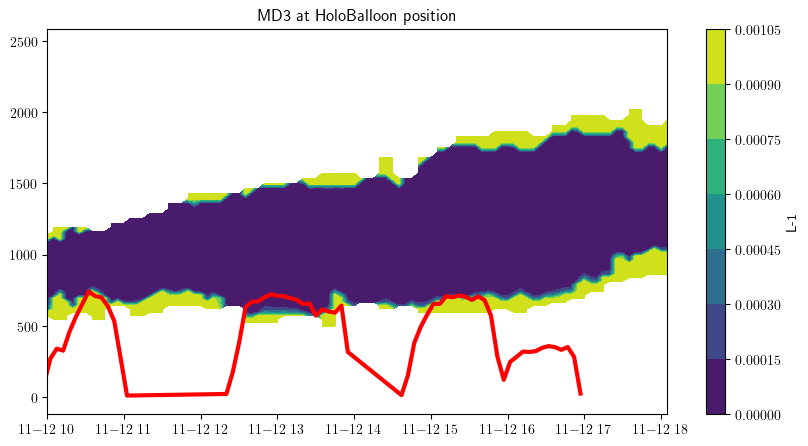

In [276]:
#MH.CLDFRA.mean(dim=['west_east', 'south_north']).T.plot()
plt.rc('text', usetex=True)
fig, ax = plt.subplots(1, 1, figsize=(10,5))
x = ICNCs[0].XTIME
#ICNCs[0].mean(dim=['west_east', 'south_north']).T.plot(x='Time', y='bottom_top', ax=ax)

X, Y = np.meshgrid(x, h)
C = ax.contourf(X, Y, IWFs[0].T / 1000)#, levels=np.arange(0, 1.1, 0.1))
#C = ax.contourf(X, Y, IWFs[0].mean(dim=['west_east', 'south_north']).T, levels=np.arange(0, 1.1, 0.1))

'''ax.plot(x, base.mean(dim=['west_east', 'south_north']), c='r', linewidth=3) #.plot(x='Time', c='r', linewidth=3)
ax.plot(x, top.mean(dim=['west_east', 'south_north']), c='r', linewidth=3)#.plot(x='Time', c='r', linewidth=3)
'''
plt.plot(data_LR.time, data_LR.instData_height, color='red', linewidth=3)
plt.colorbar(C, label='L-1')
plt.title('MD3 at HoloBalloon position')

In [242]:
h

<xarray.DataArray 'height' (bottom_top: 85)>
array([  11.3408785,   34.04713  ,   56.80371  ,   79.61095  ,
        102.47005  ,  125.38474  ,  148.3563   ,  171.38313  ,
        194.46507  ,  217.6024   ,  240.79466  ,  264.04178  ,
        287.3438   ,  310.70056  ,  334.11267  ,  357.57974  ,
        381.10104  ,  404.67712  ,  428.30814  ,  451.99432  ,
        475.73615  ,  499.5331   ,  523.38495  ,  547.292    ,
        571.2547   ,  595.27405  ,  619.34924  ,  643.4812   ,
        667.672    ,  691.9206   ,  716.2291   ,  740.60077  ,
        765.0361   ,  789.5347   ,  814.0979   ,  838.726    ,
        863.419    ,  888.1784   ,  913.0036   ,  937.8924   ,
        962.8429   ,  987.85596  , 1012.93317  , 1038.0742   ,
       1063.2799   , 1088.5518   , 1113.89     , 1139.2958   ,
       1164.7697   , 1190.3134   , 1220.2161   , 1254.5106   ,
       1288.9487   , 1323.539    , 1358.2928   , 1393.2336   ,
       1428.377    , 1463.725    , 1499.282    , 1535.0516   ,
       1571.0369   , 1607.2264   , 1643.6042   , 1680.1637   ,
       1716.9023   , 1753.8174   , 1790.9053   , 1828.1632   ,
       1865.5887   , 1903.1819   , 1940.9419   , 1978.8679   ,
       2016.9591   , 2055.214    , 2093.6353   , 2137.0706   ,
       2185.5688   , 2234.331    , 2283.3591   , 2332.6555   ,
       2382.2231   , 2432.0654   , 2482.1836   , 2532.5793   ,
       2583.2563   ], dtype=float32)
Coordinates:
    XLONG    float32 11.7
    XLAT     float32 78.84
    XTIME    float32 0.0
    Time     datetime64[ns] 2019-11-11T12:00:00
Dimensions without coordinates: bottom_top
Attributes:
    FieldType:    104
    MemoryOrder:  XYZ
    description:  model height - [MSL] (mass grid)
    units:        m
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   LambertConformal(stand_lon=11.100000381469727, moad_cen_lat...

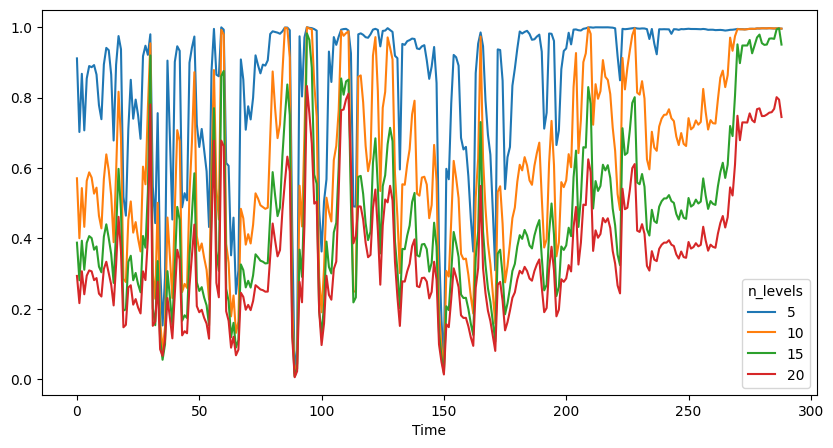

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
IWF_base = select_base(IWF, base, n_levels=5)
IWF_base.mean(dim=['west_east', 'south_north', 'bottom_top']).T.plot(ax=ax, label='5')
IWF_base = select_base(IWF, base, n_levels=10)
IWF_base.mean(dim=['west_east', 'south_north', 'bottom_top']).T.plot(ax=ax, label='10')
IWF_base = select_base(IWF, base, n_levels=15)
IWF_base.mean(dim=['west_east', 'south_north', 'bottom_top']).T.plot(ax=ax, label='15')
IWF_base = select_base(IWF, base, n_levels=20)
IWF_base.mean(dim=['west_east', 'south_north', 'bottom_top']).T.plot(ax=ax, label='20')
plt.legend(title='n_levels')

Text(0, 0.5, 'TWC')

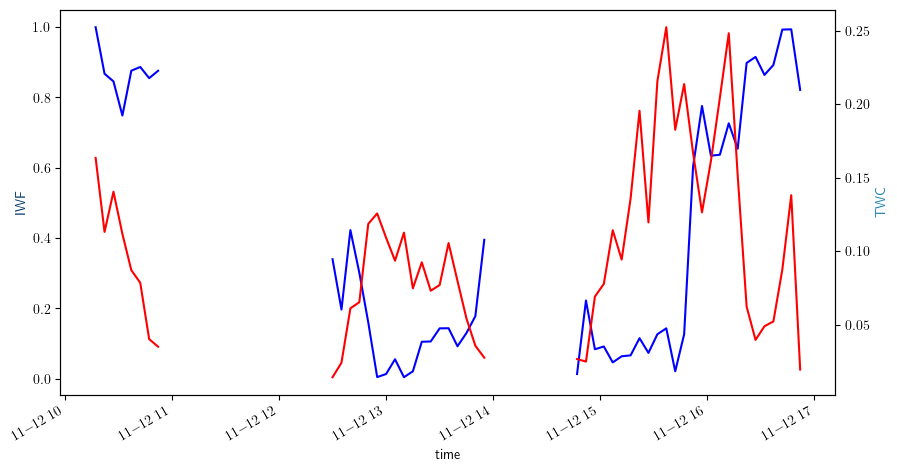

In [206]:

folderpath = '/nird/projects/NS9600K/sldam/data/Data/HoloBalloon/HoloBalloon_t300/'
data_LR = xr.open_dataset(folderpath +'NyA_merged_t300.nc')
data_LR['time'] = datenum_to_datetime(data_LR.time.to_numpy())
data_LR = data_LR.sel(time=slice(datetime(2019, 11, 12, 0, 0), datetime(2019, 11, 12, 23, 0)))

IWF_HB = holoInCloudMsk(data_LR.Ice_content / (data_LR.Water_content + data_LR.Ice_content), data_LR)
TWC_HB = holoInCloudMsk(data_LR.Ice_content + data_LR.Water_content, data_LR)
IWC_HB = holoInCloudMsk(data_LR.Ice_content, data_LR)

ICNC_HB = holoInCloudMsk(data_LR.Ice_totalCount / data_LR.Ice_volume / 1000, data_LR)

fig, ax = plt.subplots(1, 1, figsize=(10,5))
colors = ['#063970', '#1e81b0', '#e28743', '#eab676']
IWF_HB.plot(c='b', ax=ax)
ax.set_ylabel('IWF', color=colors[0])

axT = ax.twinx()
TWC_HB.plot(c='r', ax=axT)
axT.set_ylabel('TWC', color=colors[1])


In [208]:
datas[0]

<xarray.Dataset>
Dimensions:                (Time: 98, south_north: 2, west_east: 2,
                            bottom_top: 85, bottom_top_stag: 85,
                            soil_layers_stag: 4, west_east_stag: 101,
                            south_north_stag: 101, seed_dim_stag: 2)
Coordinates:
    XLAT                   (Time, south_north, west_east) float32 ...
    XLONG                  (Time, south_north, west_east) float32 ...
    XTIME                  (Time) datetime64[ns] ...
    XLAT_U                 (Time, south_north, west_east_stag) float32 ...
    XLONG_U                (Time, south_north, west_east_stag) float32 ...
    XLAT_V                 (Time, south_north_stag, west_east) float32 ...
    XLONG_V                (Time, south_north_stag, west_east) float32 ...
Dimensions without coordinates: Time, south_north, west_east, bottom_top,
                                bottom_top_stag, soil_layers_stag,
                                west_east_stag, south_north_stag, seed_dim_stag
Data variables: (12/203)
    Times                  (Time) |S19 ...
    LU_INDEX               (Time, south_north, west_east) float32 ...
    ZNU                    (Time, bottom_top) float32 ...
    ZNW                    (Time, bottom_top_stag) float32 ...
    ZS                     (Time, soil_layers_stag) float32 ...
    DZS                    (Time, soil_layers_stag) float32 ...
    ...                     ...
    PCB                    (Time, south_north, west_east) float32 ...
    PC                     (Time, south_north, west_east) float32 ...
    LANDMASK               (Time, south_north, west_east) float32 ...
    LAKEMASK               (Time, south_north, west_east) float32 ...
    SST                    (Time, south_north, west_east) float32 ...
    SST_INPUT              (Time, south_north, west_east) float32 ...
Attributes: (12/132)
    TITLE:                            OUTPUT FROM WRF V4.2.1 MODEL
    START_DATE:                      2019-11-11_12:00:00
    SIMULATION_START_DATE:           2019-11-11_12:00:00
    WEST-EAST_GRID_DIMENSION:        101
    SOUTH-NORTH_GRID_DIMENSION:      101
    BOTTOM-TOP_GRID_DIMENSION:       172
    ...                              ...
    ISLAKE:                          28
    ISICE:                           24
    ISURBAN:                         1
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2

In [367]:
data_LR.Water_content.to_numpy()

array([1.73260711e-04, 1.23712901e-05, 6.93245840e-04, 7.30574538e-05,
       2.41039553e-05, 3.84154533e-05, 1.49853852e-02, 2.16701016e-02,
       2.80695899e-02, 1.07807917e-02, 8.88391674e-03, 5.81192528e-03,
       4.33689168e-03, 3.37200823e-04, 1.55403760e-04, 8.94604539e-04,
       3.20583466e-03, 9.35326955e-03, 1.93118822e-02, 3.52351227e-02,
       4.55409038e-02, 9.94471278e-02, 1.24979161e-01, 1.07616182e-01,
       8.82675151e-02, 1.12033453e-01, 7.30697000e-02, 8.26353091e-02,
       6.52610642e-02, 6.58593816e-02, 9.03063736e-02, 7.22844282e-02,
       4.71744252e-02, 2.92394297e-02, 1.66127871e-02, 1.03495498e-03,
       4.80065867e-03, 2.61716128e-02, 1.92676198e-02, 6.32311972e-02,
       7.05558260e-02, 1.08878751e-01, 8.81761396e-02, 1.26734719e-01,
       1.72913172e-01, 1.10691365e-01, 1.88201683e-01, 2.16133498e-01,
       1.78635316e-01, 1.86608037e-01, 6.62269340e-02, 2.83378191e-02,
       5.89636702e-02, 7.41027994e-02, 6.79159623e-02, 5.23735342e-02,
      

In [196]:
HB_x, HB_y = wrf.ll_to_xy(wrfin=nc.Dataset(get_datapaths(0)), 
                        latitude=78.92759354100885, longitude=11.94456029591745, meta=False)
xslice = slice(HB_x, HB_x + 2)
yslice = slice(HB_y, HB_y + 2)
bases = [find_base(datas[i], 
        get_datapaths(i), 
        cld_thrsh=0.99, 
        xslice=xslice, 
        yslice=yslice).mean(dim=['west_east', 'south_north']) for i in tqdm.tqdm(range(4))]

100%|██████████| 4/4 [00:06<00:00,  1.61s/it]


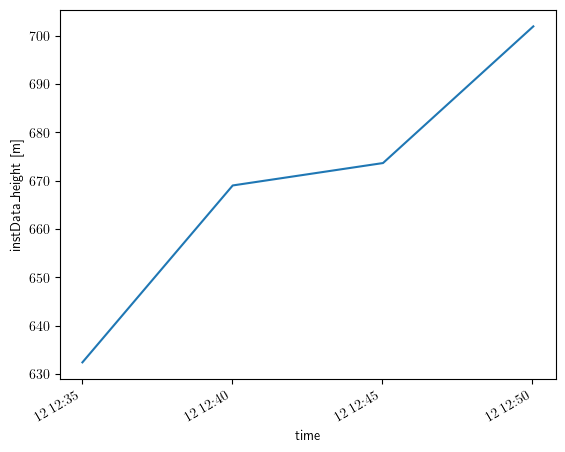

In [293]:
data_LR.instData_height.isel(time=slice(18, 22)).plot()

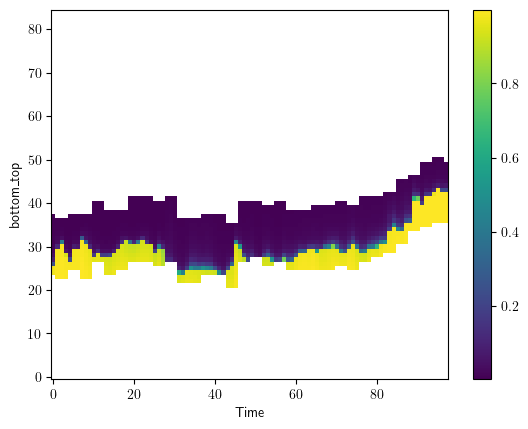

In [251]:
select_base(IWFs[0], bases[0], n_levels=15).T.plot()

In [369]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

100%|██████████| 4/4 [00:00<00:00, 19.70it/s]


(18212.416666666668, 18212.708333333332)

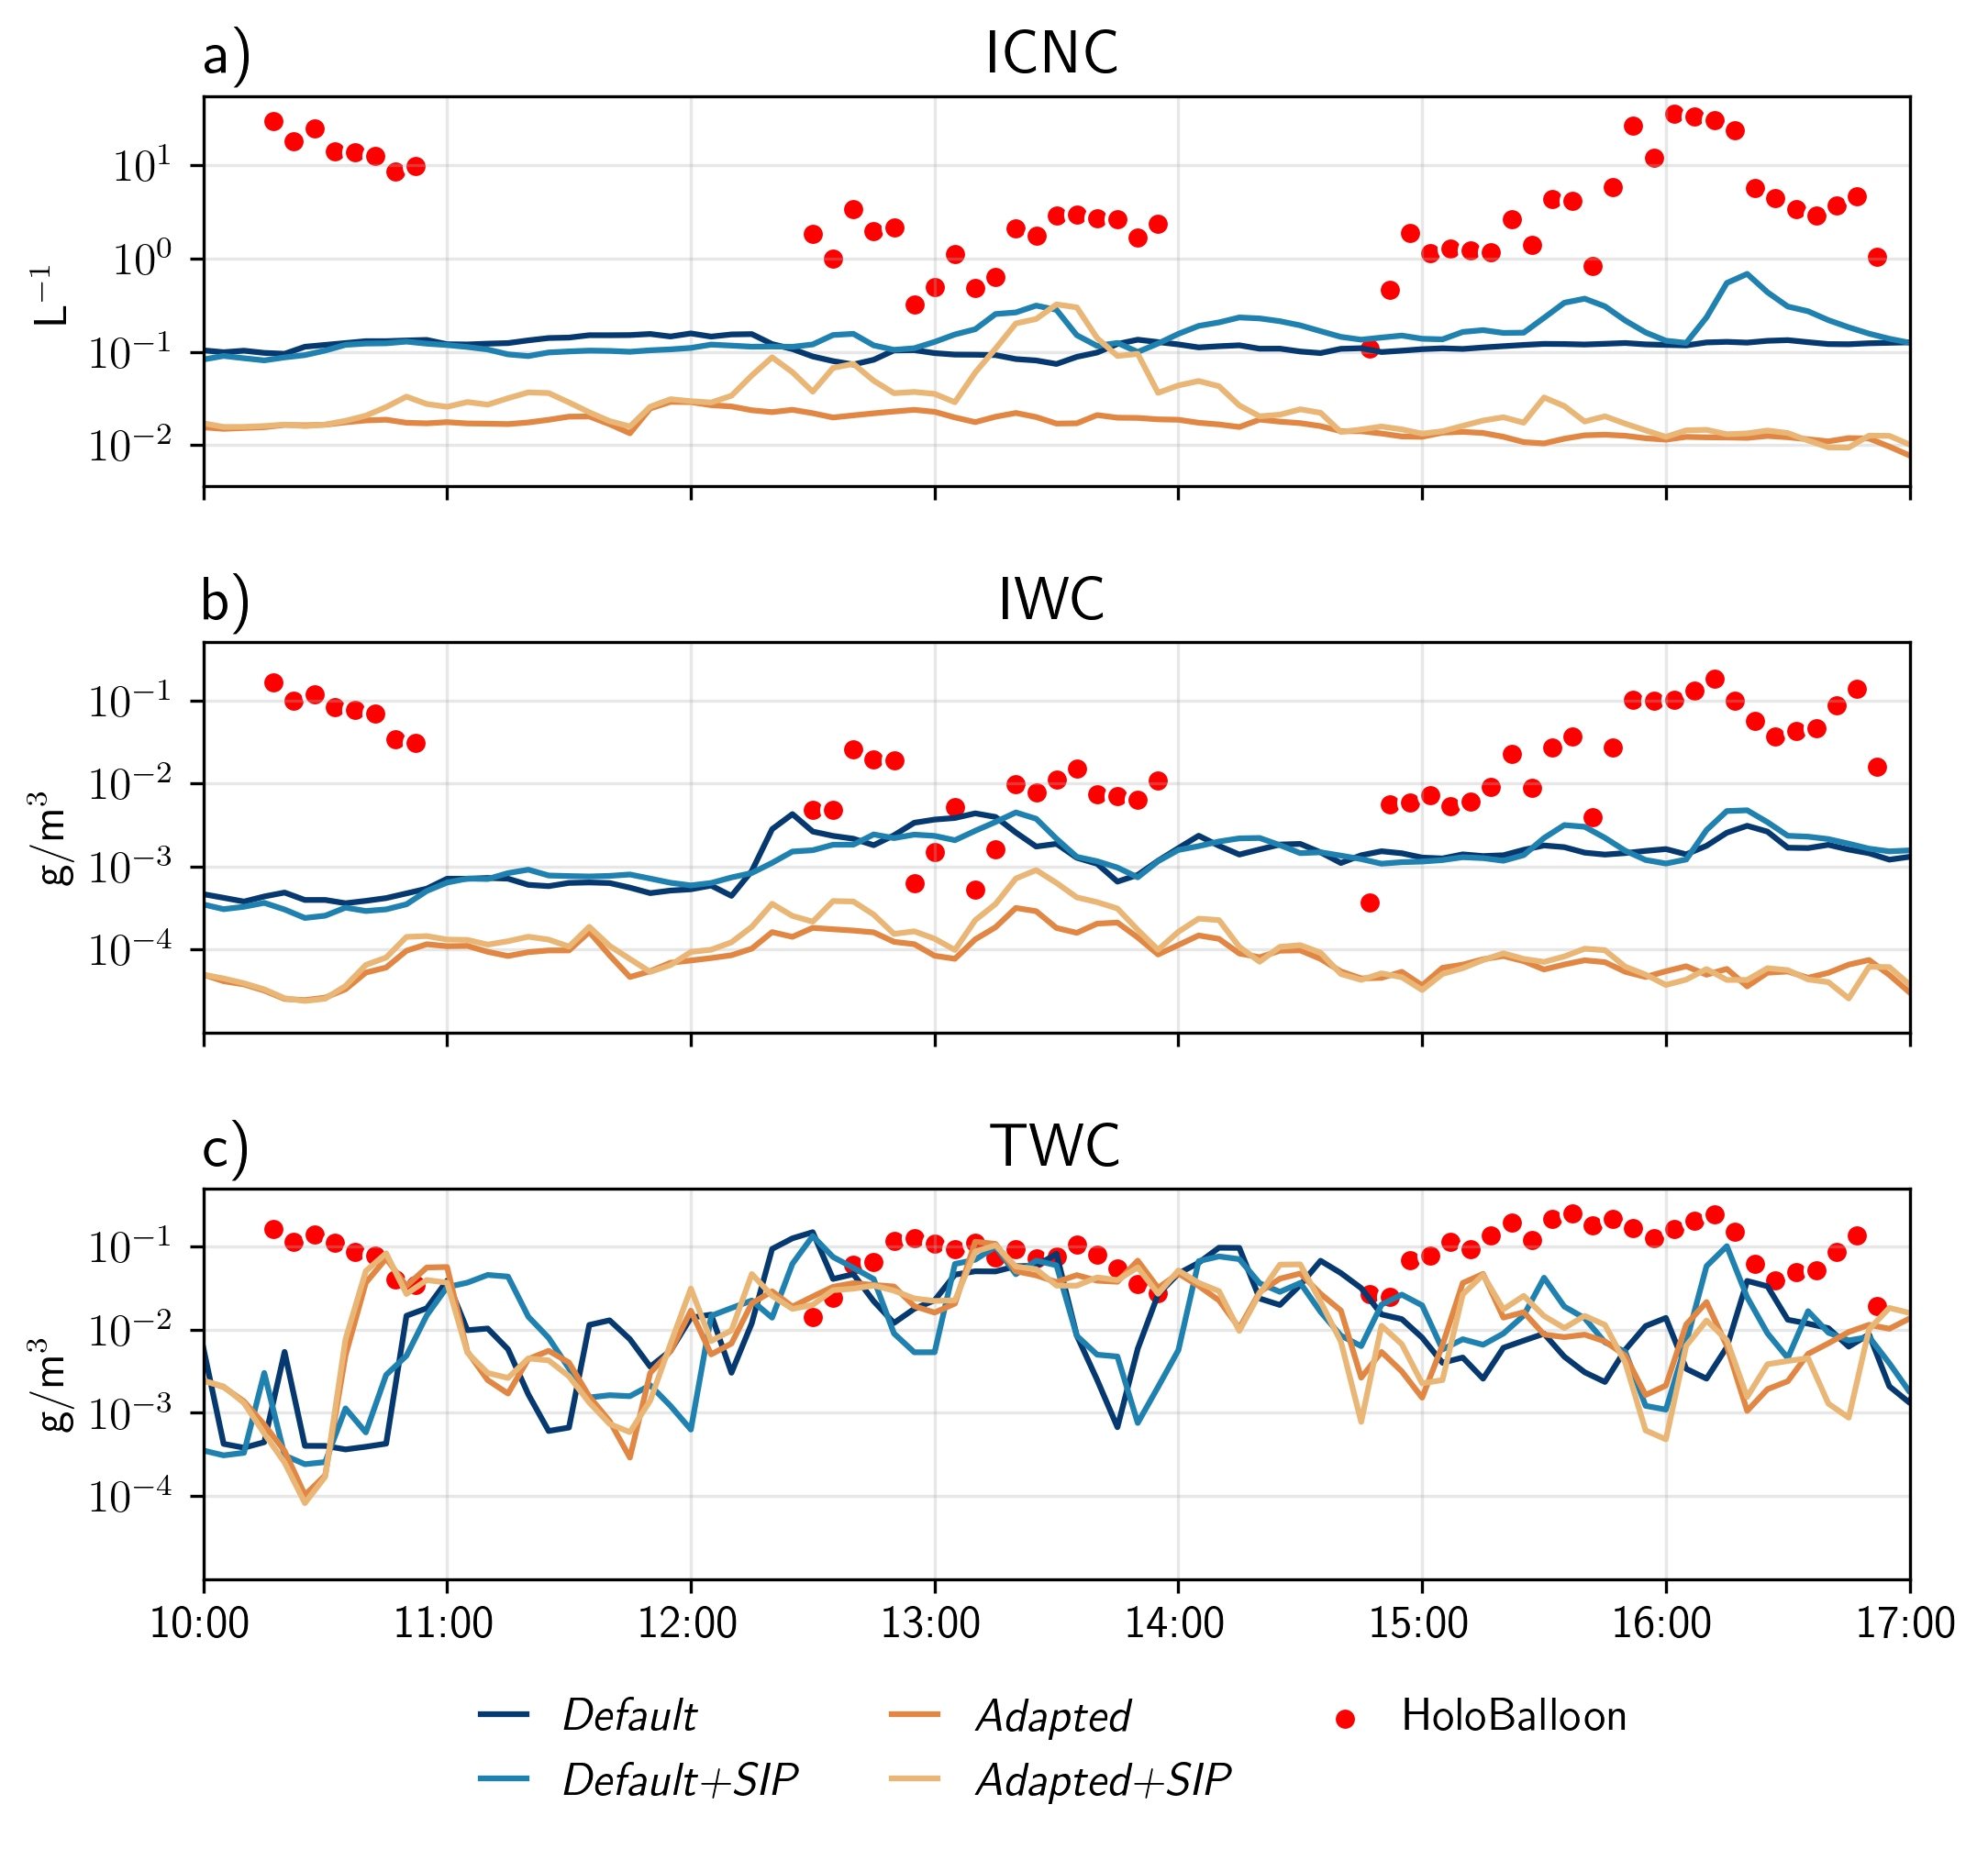

In [373]:
fig, ax = plt.subplots(3, 1, figsize=(8, 7), sharex=True)
colors = ['#063970', '#1e81b0', '#e28743', '#eab676']
labels = [r'\textit{Default}', r'\textit{Default+SIP}', r'\textit{Adapted}', r'\textit{Adapted+SIP}']
n_levels = 7


for i in tqdm.tqdm(range(4)):
    iwc_base = select_base(IWCs[i], bases[i], n_levels=n_levels).mean(dim=['bottom_top'])
    twc_base = select_base(TWCs[i], bases[i], n_levels=n_levels).mean(dim=['bottom_top'])
    
    #iwf_base = iwc_base / twc_base

    icnc_base = select_base(ICNCs[i], bases[i], n_levels=n_levels).mean(dim=['bottom_top'])
    
    ax[0].plot(ICNCs[i].XTIME, icnc_base / 1000, color=colors[i], label=labels[i])
    ax[1].plot(IWCs[i].XTIME, iwc_base, color=colors[i], label=labels[i])
    ax[2].plot(TWCs[i].XTIME, twc_base, color=colors[i], label=labels[i])
    ##ax[3].plot(IWFs[i].XTIME, iwf_base, color=colors[i], label=labels[i])

plt.legend()

ICNC_HB.plot.scatter(c='red', linewidth=3, ax=ax[0], label='HoloBalloon')
IWC_HB.plot.scatter(c='red', linewidth=3, ax=ax[1], label='HoloBalloon')
TWC_HB.plot.scatter(c='red', linewidth=3, ax=ax[2], label='HoloBalloon')
#IWF_HB.plot.scatter(c='red', linewidth=3, ax=ax[3], label='HoloBalloon')

plt.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.2), fontsize=12, 
            handlelength=1, frameon=False)

ax[0].set_ylabel('L$^{-1}$', size=12)
ax[1].set_ylabel('g/m$^3$', size=12)
ax[2].set_ylabel('g/m$^3$', size=12)
#ax[3].set_ylabel('fraction', size=12)

ax[0].set_title('ICNC', size=16)
ax[1].set_title('IWC', size=16)
ax[2].set_title('TWC', size=16)
#ax[3].set_title('IWF', size=16)

ax[0].set_xlabel(None)
ax[1].set_xlabel(None)
ax[2].set_xlabel(None)
#ax[3].set_xlabel(None)
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')

ax[0].set_yticks([0.01, 0.1, 1, 10])
ax[1].set_yticks([0.0001, 0.001, 0.01, 0.1])
ax[2].set_yticks([0.0001, 0.001, 0.01, 0.1])

ax[1].set_ylim([0.00001, 0.5])
ax[2].set_ylim([0.00001, 0.5])
#plt.suptitle(f'WRF (lower {n_levels} levels) vs HoloBalloon', size=15)
#ax[2].ticklabel_params()
labels = [str(int(a.dt.hour)) + ':00' for a in iwc_base.XTIME[::12]]
for i, x in enumerate(ax):
    x.tick_params(axis='both', labelsize=12, labelrotation=None)
    x.set_xticks(iwc_base.XTIME[::12])
    x.set_xticklabels(labels, rotation=0, ha='center')
    x.grid(alpha=0.3)
    x.text(x=0, y=1.06, s=get_subplot_label(i), transform=x.transAxes,
        fontsize=16)
plt.subplots_adjust(hspace=0.4)
ax[0].set_xlim(iwc_base.XTIME[0], iwc_base.XTIME[-14])

In [327]:
labels

["<xarray.DataArray 'hour' ()>\narray(10)\nCoordinates:\n    XTIME    datetime64[ns] 2019-11-12T10:00:00:<xarray.DataArray 'minute' ()>\narray(0)\nCoordinates:\n    XTIME    datetime64[ns] 2019-11-12T10:00:00",
 "<xarray.DataArray 'hour' ()>\narray(12)\nCoordinates:\n    XTIME    datetime64[ns] 2019-11-12T12:00:00:<xarray.DataArray 'minute' ()>\narray(0)\nCoordinates:\n    XTIME    datetime64[ns] 2019-11-12T12:00:00",
 "<xarray.DataArray 'hour' ()>\narray(14)\nCoordinates:\n    XTIME    datetime64[ns] 2019-11-12T14:00:00:<xarray.DataArray 'minute' ()>\narray(0)\nCoordinates:\n    XTIME    datetime64[ns] 2019-11-12T14:00:00",
 "<xarray.DataArray 'hour' ()>\narray(16)\nCoordinates:\n    XTIME    datetime64[ns] 2019-11-12T16:00:00:<xarray.DataArray 'minute' ()>\narray(0)\nCoordinates:\n    XTIME    datetime64[ns] 2019-11-12T16:00:00",
 "<xarray.DataArray 'hour' ()>\narray(18)\nCoordinates:\n    XTIME    datetime64[ns] 2019-11-12T18:00:00:<xarray.DataArray 'minute' ()>\narray(0)\nCoordinat

In [138]:
iwc_base[10], twc_base[10], iwc_base[10] / twc_base[10], iwf_base[10]

(<xarray.DataArray 'QICE' ()>
 array(0.000127, dtype=float32)
 Coordinates:
     XTIME    datetime64[ns] 2019-11-12T10:50:00,
 <xarray.DataArray ()>
 array(0.06104458, dtype=float32)
 Coordinates:
     XTIME    datetime64[ns] 2019-11-12T10:50:00,
 <xarray.DataArray ()>
 array(0.00208038, dtype=float32)
 Coordinates:
     XTIME    datetime64[ns] 2019-11-12T10:50:00,
 <xarray.DataArray ()>
 array(0.0111305, dtype=float32)
 Coordinates:
     XTIME    datetime64[ns] 2019-11-12T10:50:00)

100%|██████████| 4/4 [00:00<00:00, 82.02it/s]


Text(0.5, 0.98, 'TWC in WRF vs HoloBalloon, lower 15 levels')

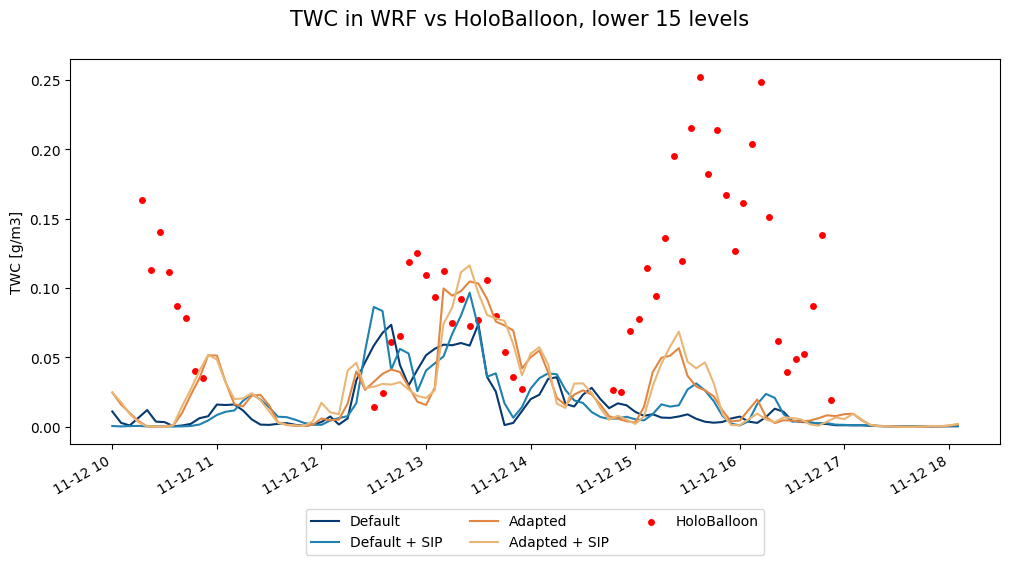

In [254]:
fig, ax = plt.subplots(1, 1, figsize=(12,5))
colors = ['#063970', '#1e81b0', '#e28743', '#eab676']
labels = ['Default', 'Default + SIP', 'Adapted', 'Adapted + SIP']
n_levels = 15

for i in tqdm.tqdm(range(4)):
    twc_base = select_base(TWCs[i], base[i], n_levels=n_levels).mean(dim=['bottom_top', 'west_east', 'south_north'])
    
    ax.plot(TWCs[i].XTIME, twc_base, color=colors[i], label=labels[i])
plt.legend()

TWC_HB.plot.scatter(c='red', linewidth=3, ax=ax, label='HoloBalloon')
plt.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.15))
ax.set_ylabel('TWC [g/m3]')
ax.set_xlabel(None)
plt.suptitle(f'TWC in WRF vs HoloBalloon, lower {n_levels} levels', size=15)

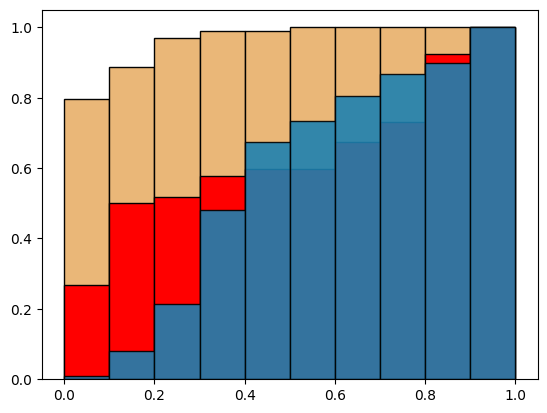

In [242]:
iwf_base3 = select_base(IWFs[3], base[3], n_levels=n_levels).mean(dim=['bottom_top', 'west_east', 'south_north'])
plt.hist(iwf_base3, bins=np.arange(0, 1.1, 0.1), alpha=0.99, edgecolor='k', color=colors[3], stacked=True, density=True, cumulative=True)

plt.hist(IWF_HB, bins=np.arange(0, 1.1, 0.1), color='red', edgecolor='k', density=True, cumulative=True, stacked=True)

iwf_base1 = select_base(IWFs[1], base[1], n_levels=n_levels).mean(dim=['bottom_top', 'west_east', 'south_north'])
plt.hist(iwf_base1, stacked=True, bins=np.arange(0, 1.1, 0.1), alpha=0.9, edgecolor='k', color=colors[1], density=True, cumulative=True)

plt.show()

In [254]:
iwf_base = [select_base(IWCs[i] / TWCs[i], bases[i], n_levels=n_levels).mean(dim=['bottom_top']) for i in range(4)]

Text(0.5, 1.0, 'Normalized occurences, lower 7 levels')

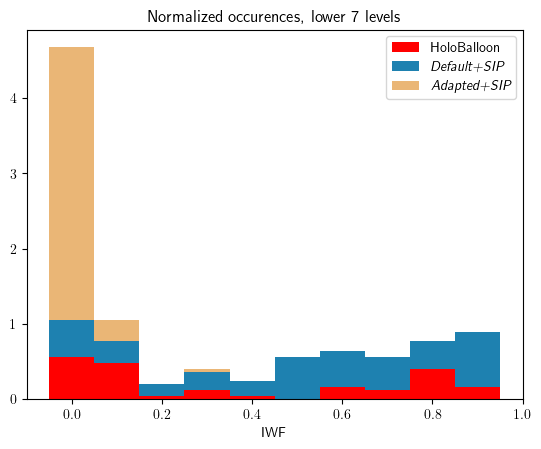

In [275]:
plt.hist([IWF_HB, iwf_base[1], iwf_base[3]], bins=np.arange(0, 1.1, 0.1), 
         density=True, stacked=True, color=['red', colors[1], colors[3]], width=0.1,
         label=['HoloBalloon', r'\textit{Default+SIP}', r'\textit{Adapted+SIP}'], align='left')
plt.xlabel('IWF')
plt.legend()
plt.title(f'Normalized occurences, lower {n_levels} levels')

Text(0.5, 1.0, 'Normalized occurences, upper 15 levels')

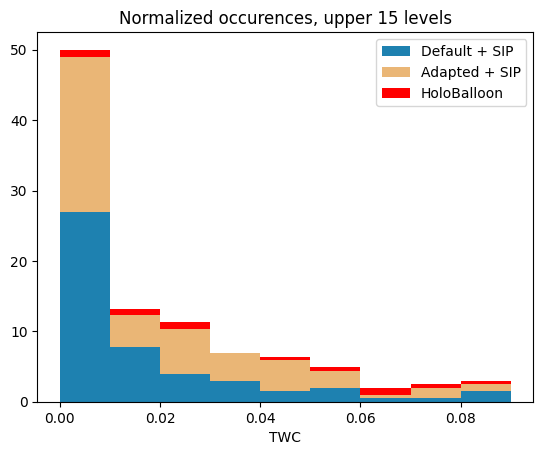

In [261]:
twc_base1 = select_base(TWCs[1], base[1], n_levels=n_levels).mean(dim=['bottom_top', 'west_east', 'south_north'])
twc_base3 = select_base(TWCs[3], base[3], n_levels=n_levels).mean(dim=['bottom_top', 'west_east', 'south_north'])
    
plt.hist([twc_base1, twc_base3, IWF_HB], bins=np.arange(0, 0.1, 0.01), 
         density=True, stacked=True, color=[colors[1], colors[3], 'red'], 
         label=['Default + SIP', 'Adapted + SIP', 'HoloBalloon'])
plt.xlabel('TWC')
plt.legend()
plt.title(f'Normalized occurences, upper {n_levels} levels')

### Plot windfield

In [95]:
def plot_windfield(t=0, datapath=Milbrandt3, p_level=800):
    # Open the NetCDF file
    ncfile = nc.Dataset(datapath)

    # Extract the pressure, geopotential height, and wind variables
    p = wrf.getvar(ncfile, "pressure", timeidx=t)
    z = wrf.getvar(ncfile, "z", units="dm", timeidx=t)
    ua = wrf.getvar(ncfile, "ua", units="m s-1", timeidx=t)
    va = wrf.getvar(ncfile, "va", units="m s-1", timeidx=t)
    wspd = wrf.getvar(ncfile, "wspd_wdir", units="m s-1", timeidx=t)[0,:]


    # Interpolate geopotential height, u, and v winds to pl hPa
    ht_pl = wrf.interplevel(z, p.isel(bottom_top=slice(0, -1)), p_level)
    u_pl = wrf.interplevel(ua, p, p_level)
    v_pl = wrf.interplevel(va, p, p_level)
    wspd_pl = wrf.interplevel(wspd, p, p_level)

    # Get the lat/lon coordinates
    lats, lons = wrf.latlon_coords(ht_pl)

    # Get the map projection information
    cart_proj = wrf.get_cartopy(ht_pl)

    # Create the figure
    fig = plt.figure(figsize=(12,9))
    ax = plt.axes(projection=cart_proj)

    ax.coastlines('50m', linewidth=0.8)

    # Add the pl hPa geopotential height contours
    levels = np.arange(750., 850., 60.)
    contours = plt.contour(wrf.to_np(lons), wrf.to_np(lats), wrf.to_np(ht_pl),
                        levels=levels, colors="black",
                        transform=ccrs.PlateCarree())
    plt.clabel(contours, inline=1, fontsize=10, fmt="%i")

    # Add the wind speed contours
    levels = np.arange(5, 25, 1)
    wspd_contours = plt.contourf(wrf.to_np(lons), wrf.to_np(lats), wrf.to_np(wspd_pl),
                                levels=levels,
                                transform=ccrs.PlateCarree())
    plt.colorbar(wspd_contours, ax=ax, orientation="horizontal", pad=.05, label='m s-1')

    # Add the pl hPa wind barbs, only plotting every 125th data point.
    plt.barbs(wrf.to_np(lons[::12,::12]), wrf.to_np(lats[::12,::12]),
            wrf.to_np(u_pl[::12, ::12]), wrf.to_np(v_pl[::12, ::12]),
            transform=ccrs.PlateCarree(), length=6)

    # Set the map bounds
    ax.set_xlim(wrf.cartopy_xlim(ht_pl))
    ax.set_ylim(wrf.cartopy_ylim(ht_pl))

    ax.gridlines()

    plt.title(f"{p_level} hPa Height Wind Speed, {domain}, t={t}")
    return fig
#plot_windfield(1, Milbrandt3, 750)

In [94]:
animate(plot_windfield, anim_title='wind_animation_d03')

100%|██████████| 232/232 [05:19<00:00,  1.38s/it]


###  Next

I'm starting to wonder if this case maybe isn't the best to look for pockets. At least the way I'm picturing it pockets are more important or relevant in persistent MPC's? This cloud looks to me like it should not be very persistent at all since it just suddenly rises and the cloud top becomes glaciated kikcing off the precip. So I'm not sure how to look for any pockets here... 
I thought about following some trajectories at cloud top and keeping track of the stats on how long each "pocket" of liquid, ice and mixed-phase are, but in this case I can't see a clear way to do that when the run is so different before and after the glaciation.


Now look at IWF for number concentration (multiply ice by factor 1000 do make comparable!)
And look at time for glaciation stuff (around 13:00) for d01 as well. Maybe this has to do with nudging!!

In [ ]:
#LAST WORKING BEFORE PARALLELLIZATION
def consecutive(arr):
    return np.split(arr, np.where(np.diff(arr) != 1)[0] + 1)

def get_wind_at_CT(data, timeidx, x, y):
    '''Find wind at cloud top level at given location and time'''
    wind = wrf.getvar(nc.Dataset(Milbrandt3), "wspd_wdir", units="m s-1", timeidx=timeidx)[0,:]
    CTL = find_top(data, Milbrandt3, t=1).isel(south_north=60, west_east=50)
    return float(wind.isel(bottom_top=CTL, west_east=x, south_north=y))


def segment_lengths(data, datapath, xy, condition='IWF > 0.5', mass=True, n_levels=7, cld_thrsh=0.5):
    '''Find length of consecutive phase segements'''
    wind = wrf.getvar(nc.Dataset(datapath), "wspd_wdir", units="m s-1", 
                      timeidx=wrf.ALL_TIMES)[0,:]

    CTL = find_top(data, datapath, cld_thrsh=cld_thrsh)

    IWF = select_top(iwf_calc(data, mass=mass, cld_thrsh=cld_thrsh), 
                     find_top(data, datapath, cld_thrsh=cld_thrsh), 
                     n_levels=n_levels).mean(dim='bottom_top')

    IWF = xr.where(IWF > 0.9, x = 1, y = IWF)
    IWF = xr.where(IWF <= 0.1, x = 0, y = IWF)
    IWF = xr.where((IWF > 0.1) & (IWF < 0.9), x = 0.5, y = IWF)

    calculations = {}

    #def f(i):
        #x, y = int(np.floor(i/10)), int(i%10)
    for e in xy:
        x, y = e
        xy_IWF = IWF.isel(south_north=y, west_east=x)
        P = np.where(eval('xy_IWF' + condition))[0]
        segment = consecutive(P)
        
        lengths = []
        for e in segment:
            length = 0
            for timeidx in e:
                H = int(CTL.isel(Time=timeidx, south_north=y, west_east=x))
                wspd = float(wind.isel(Time=timeidx, bottom_top=H, south_north=y, west_east=x))
                length += wspd * 5 * 60 # m/s * 5min timestep = meters
            lengths.append(length)
        calculations[(x, y)] = np.array(lengths)
    return calculations

res = segment_lengths(Mil3, Milbrandt3, xy=xy, condition='> 0.5')

## Comments
- How do we define 'pockets' of mixed phase to apply clustering algorithm on?
    - Are the traces around the liquid phase pocket in the middle of the cloud really mixed-phase pockets? In a clustering algorithm based purely on distances I think these would look strange
    
- Isolate the two peaks more. In 2d hist: temp above and below -10, and IWF above and below 0.5.

What about looking at upper 5 levels or so (start from cloud top, and add 5 cells below it). If they are all ice - completely glaciated, if not then mixed-phase or liquid phase is present. Maybe better way to quantify cloud pockets. Can then count in the spatial to see how many and how big the pockets typically are.